<a href="https://colab.research.google.com/github/SemanticComputing/parliamentsampo-mention-networks/blob/main/Semparl_comention_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Co-mention and bibliographical coupling networks based on person name mentions in parliamentary debate speeches

## Libraries


In [ ]:
!pip install SPARQLWrapper numpy rdflib scipy matplotlib pandas networkx sklearn
#!pip install markov_clustering[drawing]
!pip install python-louvain
!pip install cdlib
%matplotlib inline

In [ ]:
import codecs

from collections import defaultdict, OrderedDict, Counter
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from itertools import product, combinations, chain

from matplotlib import pyplot as plt
from matplotlib import cm, colors


import networkx as nx
from networkx.algorithms import community, bipartite
import numpy    as np
from cdlib import algorithms
from scipy.cluster.hierarchy import dendrogram, linkage

import pandas   as pd
import rdflib as rdflib
from rdflib.namespace import XSD, RDF, RDFS, Namespace, SKOS, OWL
import re
from scipy.interpolate import interp1d
from scipy.signal import convolve2d
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
from SPARQLWrapper import SPARQLWrapper, JSON, POST
import sys
from typing import Dict, List, Set, Tuple, Type, Union

import IPython
import pprint

from sklearn.manifold import MDS
from sklearn.metrics import pairwise

## Helper functions

In [ ]:
def checkDate(v):
  try:
    d = datetime.strptime(v, '%Y-%m-%dT%H:%M:%S').date()
  except ValueError:
    '''
    cases e.g. 29th february of a non-loop year
    '''
    m = re.match(r'(\d{4})-(\d{2})-(\d{2})', v)
    d = datetime(int(m.groups()[0]), int(m.groups()[1]), 28).date()
  return d

DATATYPECONVERTERS = {
      str(XSD.integer):  int,
      str(XSD.decimal):  float,
      str(XSD.date):     lambda v: datetime.strptime(v, '%Y-%m-%d').date(),
      str(XSD.dateTime): checkDate
  }

def convertDatatype(obj):
  return DATATYPECONVERTERS.get(obj.get('datatype'), str)(obj.get('value'))

def convertDatatypes(results):
    res = results["results"]["bindings"]
    return [dict([(k, convertDatatype(v)) for k,v in r.items()]) for r in res]

In [ ]:
from scipy.stats import rankdata

def set_stats_and_ranks(G, dct, prop = 'degree', cond = (lambda x: x>0)):
  arr = sorted(dct, key=lambda x: x[-1], reverse=True)

  for (k,v), r in zip(arr, rankdata([-v for _,v in arr], method='min')):
    if cond(v):
      # NB exporting to graphml does not support dictionaries as property values
      # G.nodes[k][prop] = {'value': v, 'rank': r} will cause an error
      G.nodes[k][prop] = v

In [ ]:
def generateGraph(nodes: Dict, links: Dict) -> (nx.Graph):

    G = nx.Graph()

    #    get all other fields except 'id' in nodes,
    #    e.g. queried parameters in SELECT ?label ?gender ...:
    node_keys = set([key for ob in nodes for key in ob.keys()]) - set(['party'])
    nodes2 = {}
    for ob in nodes:
        _id = ob['id']
        if _id + "_mentioner" in G or _id + "_mentioned" in G: # Set the group of MP as the latest group MP has belonged to
          if G.nodes[_id + "_mentioner"]['date'] < ob['date']:
            G.nodes[_id + "_mentioner"]['date'] = ob['date']
            G.nodes[_id + "_mentioner"]['group'] = ob['group']
            G.nodes[_id + "_mentioner"]['color'] = ob['color']

            G.nodes[_id + "_mentioned"]['date'] = ob['date']
            G.nodes[_id + "_mentioned"]['group'] = ob['group']
            G.nodes[_id + "_mentioned"]['color'] = ob['color']
        else:
          if 'group' in ob:
            G.add_node(_id + "_mentioner", bipartite=0)
            for key in node_keys:
                v = ob.get(key)
                if v:
                    G.nodes[_id + "_mentioner"][key] = v
            G.add_node(_id + "_mentioned", bipartite=1)
            for key in node_keys:
                v = ob.get(key)
                if v:
                    G.nodes[_id + "_mentioned"][key] = v

    #    get all other fields except 'source' and 'target' in nodes,
    #    e.g. queried parameters in SELECT ?x ?y ...:
    edge_keys = set([key for ob in links for key in ob.keys()]) - set(['source', 'target'])

    for ob in links:
        src, trg = ob['source'], ob['target']
        #if src != trg: # Are the references to oneself allowed
        if src+"_mentioner" in G.nodes and trg+"_mentioned" in G.nodes:
          if not G.has_edge(src+"_mentioner", trg+"_mentioned"):
            G.add_edge(src+"_mentioner", trg+"_mentioned")
            G.edges[src+"_mentioner", trg+"_mentioned"]['dates'] = [ob['date']] * ob['weight']
          else:
            for i in range(ob['weight']):
              G.edges[src+"_mentioner", trg+"_mentioned"]['dates'].append(ob['date'])

    for n1,n2,d in G.edges(data=True):
      d['weight'] = len(d['dates'])


          #   add query results:
          #for key in edge_keys:
          #    v = ob.get(key)
          #    if v:
          #        G.edges[src+"_mentioner", trg+"_mentioned"][key] = v

    return G

In [ ]:
def drawGraph(G,
              pos=None,
              node_color='#1f78b4',
              edge_color='grey',
              size_scale = [100,1500],
              node_size='degree',
              cmap = plt.get_cmap('viridis'),
              labels = None,
              font_size = 16,
              gov_legend=False,
              weight='weight',
              min_e = None,
              max_e = None):
  if pos is None:
    print("Adjusting layout ...")
    pos = nx.drawing.layout.fruchterman_reingold_layout(G, iterations=200)

  fig = plt.figure(figsize=[40.0, 24.0])

  ax = fig.add_subplot(111)

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)


  edge_weights = [e.get(weight,1) for _,_,e in G.edges(data=True)]
  if not min_e and not max_e:
    scale_weight =  interp1d([min(edge_weights),max(edge_weights)],[1,20])
  else:
    scale_weight =  interp1d([min_e,max_e],[1,20])
  #scale_weight =  interp1d([min(edge_weights),max(edge_weights)],[1,20])
  nx.drawing.draw_networkx_edges(G,
                                width=scale_weight(edge_weights),
                                pos=pos,
                                alpha=0.2,
                                edge_color=edge_color,
                                #connectionstyle='arc3, rad = 0.1'
                                )

  # set node size by the pagerank, and scale it to range [50,...]
  nodesizes = [e.get(node_size, 1) for _,e in G.nodes(data=True)]
  scale_size = interp1d([min(nodesizes),max(nodesizes)], size_scale)

  nx.drawing.draw_networkx_nodes(G,
                                pos=pos,
                                node_size=scale_size(nodesizes),
                                node_color = node_color,
                                #edgecolors = 'black',
                                cmap = cmap,
                                alpha=0.8
                                )

  if labels:
    nx.drawing.draw_networkx_labels(G,
                              pos=pos,
                              font_size = font_size,
                              labels = labels)
  if gov_legend:
    plt.scatter([],[], c='#0F4DBC', label='Goverment')
    plt.scatter([],[], c='#BF1E24', label='Opposition')
    plt.legend()

  plt.show()
  return pos

## Constants

Constants related to queries

In [ ]:
ENDPOINT = "http://ldf.fi/semparl/sparql"

PREFIXES = """
PREFIX bioc: <http://ldf.fi/schema/bioc/>
PREFIX crm: <http://erlangen-crm.org/current/>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX districts: <http://ldf.fi/semparl/groups/districts/>
PREFIX event: <http://ldf.fi/semparl/event/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX groups: <http://ldf.fi/semparl/groups/>
PREFIX label: <http://ldf.fi/semparl/label/>
PREFIX occupations: <http://ldf.fi/semparl/occupations/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX people: <http://ldf.fi/semparl/people/>
PREFIX places: <http://ldf.fi/semparl/places/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX roles: <http://ldf.fi/semparl/roles/>
PREFIX schema: <http://schema.org/>
PREFIX semparls: <http://ldf.fi/schema/semparl/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX times: <http://ldf.fi/semparl/times/>
PREFIX eterms: <http://ldf.fi/semparl/times/electoral-terms/>
PREFIX titles: <http://ldf.fi/semparl/titles/>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX semparl_linguistics: <http://ldf.fi/schema/semparl/linguistics/>
"""

Time period and electoral term for queries


In [ ]:
_start, _end = '2015-04-22', '2019-04-16'
eterm = 'eterms:e_2015-04-22-2019-04-16'
#_start, _end = '2019-04-24', '2022-05-31'

In [ ]:
sparql = SPARQLWrapper(ENDPOINT)
sparql.setQuery(PREFIXES+"""
SELECT DISTINCT ?source ?target ?date (COUNT(DISTINCT ?sp) AS ?weight) WHERE {
  BIND('<START>'^^xsd:date AS ?start)
  BIND('<END>'^^xsd:date AS ?end)

 ?sp semparl_linguistics:referenceToPerson/skos:relatedMatch ?target ;
     semparls:speaker ?source ;
     dct:date ?date
  FILTER (?source != ?target)
  FILTER (?start<=?date && ?date <= ?end)
  ?sp semparls:speechType ?type .
  FILTER (?type != <http://ldf.fi/semparl/speechtypes/PuhemiesPuheenvuoro>) .
  ?sp dct:language <http://id.loc.gov/vocabulary/iso639-2/fin> .

  ?target bioc:bearer_of/crm:P11i_participated_in ?event .
  ?event a semparls:ParliamentaryGroupMembership .
  ?event crm:P10_falls_within <ETERM> .
  ?event crm:P4_has_time-span ?tspant .
  ?tspant crm:P81a_begin_of_the_begin ?t_startt .
  OPTIONAL { ?tspant crm:P82b_end_of_the_end ?t_endt }
  FILTER (?t_startt <= ?date && (!BOUND(?t_endt) || ?t_endt >= ?date))


  # Filter that referenced person (?target) is a current MP or minister
  #VALUES ?eclass {
  #  semparls:ParliamentMembership
  #  semparls:ParliamentaryGroupMembership
	#semparls:GovernmentMembership
  #}
  #?target bioc:bearer_of/crm:P11i_participated_in [
  #    a ?eclass ;
  #    crm:P4_has_time-span ?tspan ] .

  #?tspan crm:P81a_begin_of_the_begin ?t_start .
  #OPTIONAL { ?tspan crm:P82b_end_of_the_end ?t_end }

  #FILTER (?t_start <= ?date && (!BOUND(?t_end) || ?date <= ?t_end))

}
GROUP BY ?source ?target ?date """.replace("<START>", _start).replace("<END>", _end).replace('<ETERM>',eterm))

sparql.setReturnFormat(JSON)
sparql.setMethod(POST)

results = sparql.query().convert()
results2 = convertDatatypes(results)
print("Number of links:", len(results2))

Number of links: 32226


In [ ]:
print(sum([ob['weight'] for ob in results2]))

37170


## Query MPs and their parties

In [ ]:
# Get unique node ids from the links
uniq_ids = set({ob.get('source') for ob in results2}) | set({ob.get('target') for ob in results2})
BLOCK = ' '.join({"<{}>".format(s) for s in uniq_ids})
print(len(uniq_ids))
q = """
SELECT DISTINCT ?id ?label ?group ?date (sample(?colors) AS ?color) WHERE {
  VALUES ?id { <BLOCK> }
  ?id skos:prefLabel ?label .
  ?id semparls:has_party_membership ?partyms .
  ?partyms semparls:party ?group .
  ?group semparls:hexcolor ?colors .
  ?partyms crm:P4_has_time-span ?tspan .
  ?tspan crm:P81a_begin_of_the_begin ?date .
  #FILTER(?group != groups:Q30337076 || (?group=groups:Q30337076 && ?date >= "2017-06-13"^^xsd:date))
} GROUP BY ?id ?label ?group ?date
ORDER BY ?id""".replace('<BLOCK>', BLOCK)

sparql.setQuery(PREFIXES + q)
results = sparql.query().convert()

vars = results['head']['vars']
res_nodes = convertDatatypes(results)

for ob in res_nodes[:10]:
  print(ob)

215
{'id': 'http://ldf.fi/semparl/people/p1031', 'label': 'Stubb, Alexander (1968-)', 'group': 'http://ldf.fi/semparl/groups/Q304191', 'date': datetime.date(2008, 4, 4), 'color': '#00587C'}
{'id': 'http://ldf.fi/semparl/people/p1041', 'label': 'Saarakkala, Vesa-Matti (1984-)', 'group': 'http://ldf.fi/semparl/groups/Q30337076', 'date': datetime.date(2017, 6, 13), 'color': '#FF5500'}
{'id': 'http://ldf.fi/semparl/people/p1041', 'label': 'Saarakkala, Vesa-Matti (1984-)', 'group': 'http://ldf.fi/semparl/groups/Q634277', 'date': datetime.date(2011, 4, 20), 'color': '#FFDE55'}
{'id': 'http://ldf.fi/semparl/people/p1056', 'label': 'Jokinen, Kalle (1961-)', 'group': 'http://ldf.fi/semparl/groups/Q304191', 'date': datetime.date(2009, 9, 9), 'color': '#00587C'}
{'id': 'http://ldf.fi/semparl/people/p1087', 'label': 'Mäkisalo-Ropponen, Merja (1958-)', 'group': 'http://ldf.fi/semparl/groups/Q499029', 'date': datetime.date(2011, 4, 20), 'color': '#E11931'}
{'id': 'http://ldf.fi/semparl/people/p1088'

In [ ]:
# Query parties
uniq_ids2 = set({ob.get('group') for ob in res_nodes})
BLOCK2 = ' '.join({"<{}>".format(s) for s in uniq_ids2})

q = """
SELECT DISTINCT ?group ?label WHERE {
  VALUES ?group { <BLOCK> }
  ?group skos:prefLabel ?label .
  FILTER(LANG(?label)='fi') .
  }""".replace('<BLOCK>', BLOCK2)

sparql.setQuery(PREFIXES + q)
results = sparql.query().convert()
res_labels = convertDatatypes(results)

group_names = {}
for ob in res_labels:
  group_names[ob['group']] = ob['label']
print(group_names)

{'http://ldf.fi/semparl/groups/Q30337076': 'Korjausliike', 'http://ldf.fi/semparl/groups/Q1854411': 'Suomen Maaseudun Puolue', 'http://ldf.fi/semparl/groups/Q506591': 'Suomen Keskusta', 'http://ldf.fi/semparl/groups/Q196695': 'Vihreä liitto', 'http://ldf.fi/semparl/groups/Q634277': 'Perussuomalaiset', 'http://ldf.fi/semparl/groups/Q845537': 'Suomen ruotsalainen kansanpuolue', 'http://ldf.fi/semparl/groups/Q58868602': 'Seitsemän tähden liike', 'http://ldf.fi/semparl/groups/Q499029': 'Suomen Sosialidemokraattinen Puolue', 'http://ldf.fi/semparl/groups/Q1138982': 'Suomen Kristillisdemokraatit', 'http://ldf.fi/semparl/groups/Q304191': 'Kansallinen Kokoomus', 'http://ldf.fi/semparl/groups/Q52157683': 'Liike Nyt', 'http://ldf.fi/semparl/groups/Q385927': 'Vasemmistoliitto'}


In [ ]:
# Government parties
govenrment = ['http://ldf.fi/semparl/groups/Q30337076', 'http://ldf.fi/semparl/groups/Q634277', 'http://ldf.fi/semparl/groups/Q506591','http://ldf.fi/semparl/groups/Q304191']
#government = ['http://ldf.fi/semparl/groups/Q499029', 'http://ldf.fi/semparl/groups/Q506591', 'http://ldf.fi/semparl/groups/Q196695', 'http://ldf.fi/semparl/groups/Q385927','http://ldf.fi/semparl/groups/Q845537']

gov_c = '#0F4DBC'
opp_c = '#BF1E24'

In [ ]:
# Output node and link data in the networkx graph
G = generateGraph(res_nodes, results2)

# Remove Eija Nivala ja Pirkko Ruohonen-Lerner, who were MPs for a very short time
G.remove_nodes_from(['http://ldf.fi/semparl/people/p920_mentioner', 'http://ldf.fi/semparl/people/p1381_mentioner', 'http://ldf.fi/semparl/people/p920_mentioned', 'http://ldf.fi/semparl/people/p1381_mentioned'])

print('Samples of links:')
for e in list(G.edges(data=True))[:10]:
  print(e)
print('...')
print('Samples of nodes:')
for u in list(G.nodes(data=True))[:10]:
  print(u)

mentioner_mps = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
mentioned_mps = set(G) - mentioner_mps

nn=50

Samples of links:
('http://ldf.fi/semparl/people/p1031_mentioner', 'http://ldf.fi/semparl/people/p932_mentioned', {'dates': [datetime.date(2015, 6, 29)], 'weight': 1})
('http://ldf.fi/semparl/people/p1031_mentioner', 'http://ldf.fi/semparl/people/p917_mentioned', {'dates': [datetime.date(2015, 9, 24), datetime.date(2015, 9, 29), datetime.date(2015, 11, 12), datetime.date(2015, 11, 26), datetime.date(2016, 2, 4), datetime.date(2015, 11, 18), datetime.date(2016, 6, 2)], 'weight': 7})
('http://ldf.fi/semparl/people/p1031_mentioner', 'http://ldf.fi/semparl/people/p1147_mentioned', {'dates': [datetime.date(2016, 4, 7), datetime.date(2016, 4, 19), datetime.date(2015, 10, 8), datetime.date(2015, 6, 2), datetime.date(2015, 11, 3), datetime.date(2016, 5, 26), datetime.date(2015, 11, 24), datetime.date(2016, 3, 30), datetime.date(2015, 12, 3), datetime.date(2015, 12, 3), datetime.date(2016, 3, 3), datetime.date(2016, 3, 3)], 'weight': 12})
('http://ldf.fi/semparl/people/p1031_mentioner', 'http:/

In [ ]:
print("The largest number of mentions from one MP to another:")
sorted_edges = sorted(G.edges(data=True), key=lambda t: t[2]['weight'], reverse=True)
for n1,n2,d in sorted_edges[:20]:
  print("{:3d}  {:35s} {:40s} {:35s} {:40s}".format(d['weight'], G.nodes[n1]['label'], group_names[G.nodes[n1]['group']], G.nodes[n2]['label'], group_names[G.nodes[n2]['group']]))

The largest number of mentions from one MP to another:
105  Viitanen, Pia (1967-)               Suomen Sosialidemokraattinen Puolue      Heinäluoma, Eero (1955-)            Suomen Sosialidemokraattinen Puolue     
 85  Rinne, Antti (1962-)                Suomen Sosialidemokraattinen Puolue      Orpo, Petteri (1969-)               Kansallinen Kokoomus                    
 84  Sipilä, Juha (1961-)                Suomen Keskusta                          Rinne, Antti (1962-)                Suomen Sosialidemokraattinen Puolue     
 83  Viitanen, Pia (1967-)               Suomen Sosialidemokraattinen Puolue      Orpo, Petteri (1969-)               Kansallinen Kokoomus                    
 79  Sipilä, Juha (1961-)                Suomen Keskusta                          Arhinmäki, Paavo (1976-)            Vasemmistoliitto                        
 77  Harakka, Timo (1962-)               Suomen Sosialidemokraattinen Puolue      Viitanen, Pia (1967-)               Suomen Sosialidemokraattinen Puo

In [ ]:
dct = G.degree(mentioner_mps, weight=None)
print("MPs that have mentioned the largest number of other MPs:")
arr = sorted(dct, key=lambda x: x[-1], reverse=True)
for v,u in arr[:15]:
  print(u, G.nodes[v])

MPs that have mentioned the largest number of other MPs:
173 {'bipartite': 0, 'label': 'Heinonen, Timo (1975-)', 'color': '#00587C', 'group': 'http://ldf.fi/semparl/groups/Q304191', 'id': 'http://ldf.fi/semparl/people/p967', 'date': datetime.date(2007, 3, 21)}
168 {'bipartite': 0, 'label': 'Myllykoski, Jari (1959-)', 'color': '#BF1E24', 'group': 'http://ldf.fi/semparl/groups/Q385927', 'id': 'http://ldf.fi/semparl/people/p1154', 'date': datetime.date(2011, 4, 20)}
147 {'bipartite': 0, 'label': 'Lindström, Jari (1965-)', 'color': '#FF5500', 'group': 'http://ldf.fi/semparl/groups/Q30337076', 'id': 'http://ldf.fi/semparl/people/p1146', 'date': datetime.date(2015, 5, 29)}
145 {'bipartite': 0, 'label': 'Hoskonen, Hannu (1957-)', 'color': '#01954B', 'group': 'http://ldf.fi/semparl/groups/Q506591', 'id': 'http://ldf.fi/semparl/people/p797', 'date': datetime.date(2003, 3, 19)}
143 {'bipartite': 0, 'label': 'Elo, Simon (1986-)', 'color': '#FF5500', 'group': 'http://ldf.fi/semparl/groups/Q3033707

In [ ]:
dct = G.degree(mentioner_mps, weight='weight')
set_stats_and_ranks(G, dct, 'degree')
print("MPs that have made the largest number of person name mentions")
arr = sorted(dct, key=lambda x: x[-1], reverse=True)
for v,u in arr[:15]:
  print(u, G.nodes[v])
mentioner_labels = [G.nodes[v]['label'] for v,_ in arr[:nn]]
mentioner_ids = [v for v,_ in arr[:nn]]

MPs that have made the largest number of person name mentions
1178 {'bipartite': 0, 'label': 'Viitanen, Pia (1967-)', 'color': '#E11931', 'group': 'http://ldf.fi/semparl/groups/Q499029', 'id': 'http://ldf.fi/semparl/people/p511', 'date': datetime.date(1995, 3, 24), 'degree': 1178}
1044 {'bipartite': 0, 'label': 'Heinonen, Timo (1975-)', 'color': '#00587C', 'group': 'http://ldf.fi/semparl/groups/Q304191', 'id': 'http://ldf.fi/semparl/people/p967', 'date': datetime.date(2007, 3, 21), 'degree': 1044}
961 {'bipartite': 0, 'label': 'Zyskowicz, Ben (1954-)', 'color': '#00587C', 'group': 'http://ldf.fi/semparl/groups/Q304191', 'id': 'http://ldf.fi/semparl/people/p301', 'date': datetime.date(1979, 3, 24), 'degree': 961}
842 {'bipartite': 0, 'label': 'Myllykoski, Jari (1959-)', 'color': '#BF1E24', 'group': 'http://ldf.fi/semparl/groups/Q385927', 'id': 'http://ldf.fi/semparl/people/p1154', 'date': datetime.date(2011, 4, 20), 'degree': 842}
830 {'bipartite': 0, 'label': 'Hoskonen, Hannu (1957-)',

In [ ]:
dct = G.degree(mentioned_mps, weight=None)
print("MPs who have been mentioned by many other MPs:")
arr = sorted(dct, key=lambda x: x[-1], reverse=True)
for v,u in arr[:25]:
  print("{:3d} {:25s} {}".format(u, v, G.nodes[v]))

MPs who have been mentioned by many other MPs:
177 http://ldf.fi/semparl/people/p1108_mentioned {'bipartite': 1, 'label': 'Sipilä, Juha (1961-)', 'color': '#01954B', 'group': 'http://ldf.fi/semparl/groups/Q506591', 'id': 'http://ldf.fi/semparl/people/p1108', 'date': datetime.date(2011, 4, 20)}
156 http://ldf.fi/semparl/people/p947_mentioned {'bipartite': 1, 'label': 'Orpo, Petteri (1969-)', 'color': '#00587C', 'group': 'http://ldf.fi/semparl/groups/Q304191', 'id': 'http://ldf.fi/semparl/people/p947', 'date': datetime.date(2007, 3, 21)}
150 http://ldf.fi/semparl/people/p1146_mentioned {'bipartite': 1, 'label': 'Lindström, Jari (1965-)', 'color': '#FF5500', 'group': 'http://ldf.fi/semparl/groups/Q30337076', 'id': 'http://ldf.fi/semparl/people/p1146', 'date': datetime.date(2015, 5, 29)}
150 http://ldf.fi/semparl/people/p967_mentioned {'bipartite': 1, 'label': 'Heinonen, Timo (1975-)', 'color': '#00587C', 'group': 'http://ldf.fi/semparl/groups/Q304191', 'id': 'http://ldf.fi/semparl/people/

In [ ]:
print("MPs who have been mentioned most often:")
dct = G.degree(mentioned_mps, weight='weight')
set_stats_and_ranks(G, dct, 'degree')
arr = sorted(dct, key=lambda x: x[-1], reverse=True)
for v,u in arr[:25]:
  print("{:5d} {:25s} {}".format(u, v, G.nodes[v]))
mentioned_labels = [G.nodes[v]['label'] for v,_ in arr[:nn]]
mentioned_ids = [v for v,_ in arr[:nn]]

MPs who have been mentioned most often:
 1725 http://ldf.fi/semparl/people/p1108_mentioned {'bipartite': 1, 'label': 'Sipilä, Juha (1961-)', 'color': '#01954B', 'group': 'http://ldf.fi/semparl/groups/Q506591', 'id': 'http://ldf.fi/semparl/people/p1108', 'date': datetime.date(2011, 4, 20), 'degree': 1725}
 1293 http://ldf.fi/semparl/people/p947_mentioned {'bipartite': 1, 'label': 'Orpo, Petteri (1969-)', 'color': '#00587C', 'group': 'http://ldf.fi/semparl/groups/Q304191', 'id': 'http://ldf.fi/semparl/people/p947', 'date': datetime.date(2007, 3, 21), 'degree': 1293}
  994 http://ldf.fi/semparl/people/p301_mentioned {'bipartite': 1, 'label': 'Zyskowicz, Ben (1954-)', 'color': '#00587C', 'group': 'http://ldf.fi/semparl/groups/Q304191', 'id': 'http://ldf.fi/semparl/people/p301', 'date': datetime.date(1979, 3, 24), 'degree': 994}
  906 http://ldf.fi/semparl/people/p1146_mentioned {'bipartite': 1, 'label': 'Lindström, Jari (1965-)', 'color': '#FF5500', 'group': 'http://ldf.fi/semparl/groups/Q

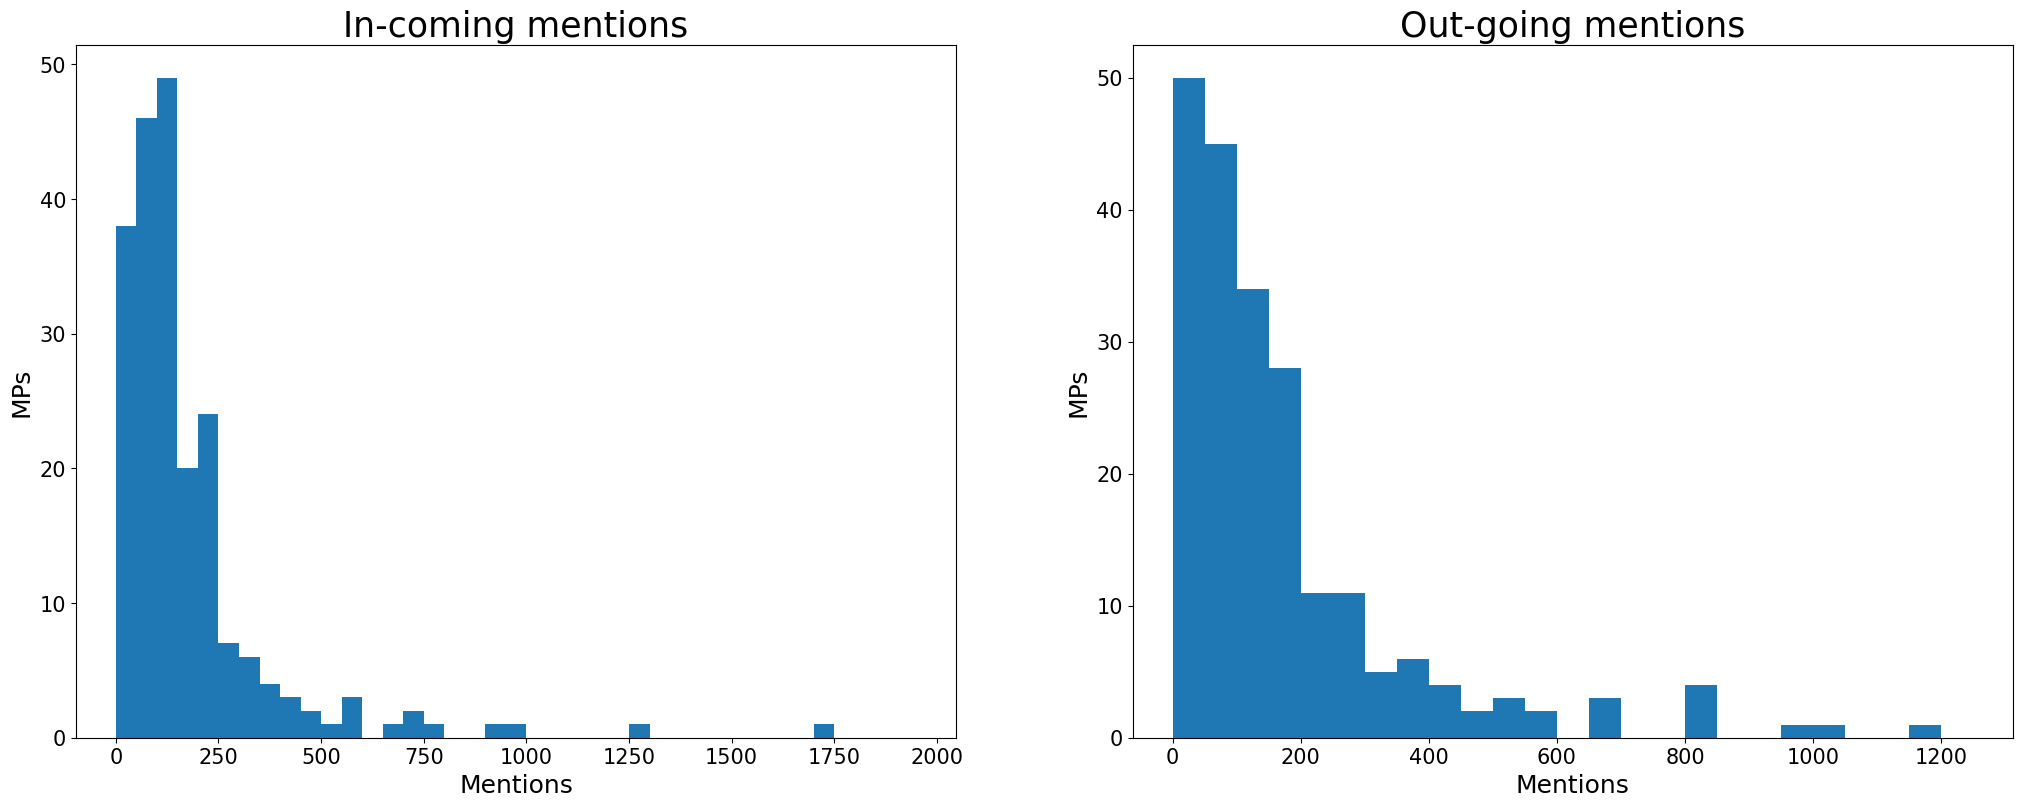

In [ ]:
dct = G.degree(mentioned_mps, weight='weight')
arr1 = sorted(dct, key=lambda x: x[-1], reverse=True)
fig = plt.figure(figsize=[25.0, 9.0])
ax1 = fig.add_subplot(1,2,1)
values1 = [u for _,u in arr1 ]
n, bins, patches = ax1.hist(values1, bins=np.arange(0,2000,50))
ax1.set_title("In-coming mentions",fontdict={'fontsize':25})
ax1.set_xlabel('Mentions', fontdict={'fontsize':18})
ax1.set_ylabel('MPs', fontdict={'fontsize':18})
ax1.tick_params(axis='both', which='major', labelsize=15)

dct = G.degree(mentioner_mps, weight='weight')
arr = sorted(dct, key=lambda x: x[-1], reverse=True)
ax2 = fig.add_subplot(1,2,2)
values2 = [u for _,u in arr ]
n, bins, patches = ax2.hist(values2, bins=np.arange(0,1300,50))
ax2.set_title("Out-going mentions",fontdict={'fontsize':25})
ax2.set_xlabel('Mentions', fontdict={'fontsize':18})
ax2.set_ylabel('MPs', fontdict={'fontsize':18})
ax2.tick_params(axis='both', which='major', labelsize=15)


## Create projections of MPs

Create co-citation network and bibliographical coupling network from bipartite network as projections. For example, if in the figure below yellow nodes are nodes that make mentions and green nodes receive mentions bibliographical coupling network can be constructed from yellow nodes and co-citation network from green nodes. There is multiple ways to calculate link weights based on the original network for new networks.

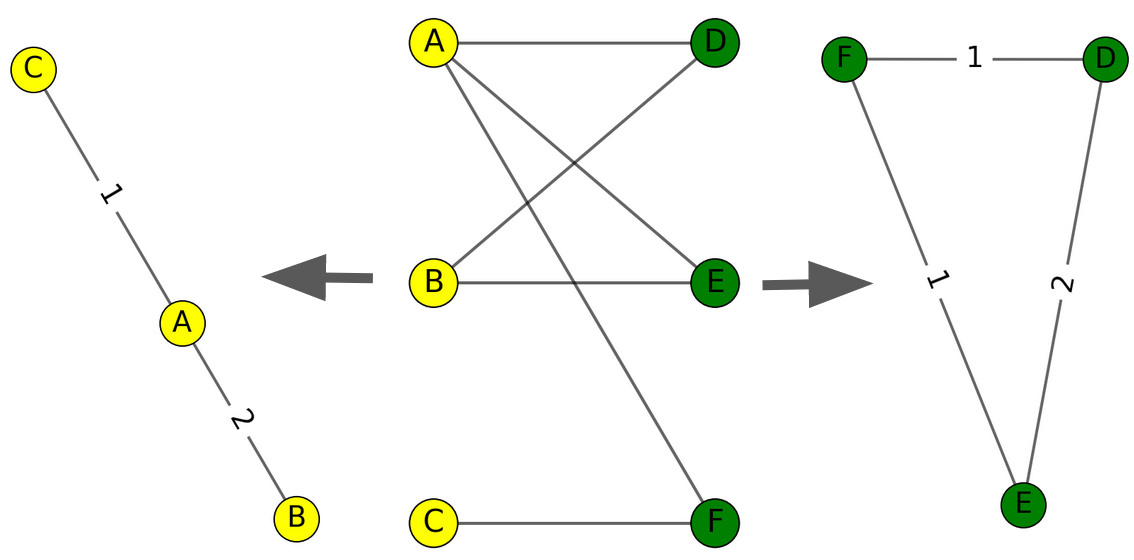

In [ ]:
# For co-citation networks

# Minimum methos
def weight_fun_min1(G,u,v):
  weight = 0
  for n in G.nodes:
    if G.has_edge(n,u) and G.has_edge(n,v):
      weight += min(G[n][u]['weight'], G[n][v]['weight'])
  return weight

# Combined method
def weight_fun_comb1(G,u,v):
  weight = 0
  for n in G.nodes:
    if G.has_edge(n,u) and G.has_edge(n,v):
      weight += G[n][u]['weight']*G[n][v]['weight']
  return weight

# Count co-citation only when citations happen in same time window
def weight_fun_timewindow1(G,u,v):
  WINDOW = 7 # Number of days
  weight = 0
  for n in G.nodes:
    if G.has_edge(n,u) and G.has_edge(n,v):
      dates1 = sorted(G.edges[n,u]['dates'])
      dates2 = sorted(G.edges[n,v]['dates'])
      if len(dates1) < len(dates2):
        for d1 in dates1:
          for d2 in dates2:
            delta = d1-d2
            if abs(delta.days) <= WINDOW:
              dates2.remove(d2)
              weight += 1
              break
      else:
        for d1 in dates2:
          for d2 in dates1:
            delta = d1-d2
            if abs(delta.days) <= WINDOW:
              dates1.remove(d2)
              weight += 1
              break
  return weight

In [ ]:
# For bibliographical coupling networks

def weight_fun_min2(G,u,v):
  weight = 0
  for n in G.nodes:
    if u != v and G.has_edge(u,n) and G.has_edge(v,n):
      weight += min(G[u][n]['weight'], G[v][n]['weight'])
  return weight

# Combined method
def weight_fun_comb2(G,u,v):
  weight = 0
  for n in G.nodes:
    if G.has_edge(u,n) and G.has_edge(v,n):
      weight += G[u][n]['weight']*G[v][n]['weight']
  return weight

# Count bibliographical coupling only when citations happen in same time window
def weight_fun_timewindow2(G,u,v):
  WINDOW = 7 # Number of days
  weight = 0
  for n in G.nodes:
    if G.has_edge(u,n) and G.has_edge(v,n):
      dates1 = sorted(G.edges[u,n]['dates'])
      dates2 = sorted(G.edges[v,n]['dates'])
      if len(dates1) < len(dates2):
        for d1 in dates1:
          for d2 in dates2:
            delta = d1-d2
            if abs(delta.days) <= WINDOW:
              dates2.remove(d2)
              weight += 1
              break
      else:
        for d1 in dates2:
          for d2 in dates1:
            delta = d1-d2
            if abs(delta.days) <= WINDOW:
              dates1.remove(d2)
              weight += 1
              break
  return weight

In [ ]:
# If weigth_function is not defined, the link weight will be the number of common neighbors in the original network
co_mention = False
if co_mention: # Co-citation networks
  G2_nodes = mentioned_mps
  G2_50_ids = mentioned_ids
  G2_50_labels = mentioned_labels
  G2 = bipartite.generic_weighted_projected_graph(G, G2_nodes, weight_function=weight_fun_min1)
else: # Bibliographical network
  G2_nodes = mentioner_mps
  G2_50_ids= mentioner_ids
  G2_50_labels = mentioner_labels
  G2 = bipartite.generic_weighted_projected_graph(G, G2_nodes, weight_function=weight_fun_min2)


print('Samples of links:')
for e in list(G2.edges(data=True))[:10]:
  print(e)
print('...')
print('Samples of nodes:')
for u in list(G2.nodes(data=True))[:10]:
  print(u)

Samples of links:
('http://ldf.fi/semparl/people/p1347_mentioner', 'http://ldf.fi/semparl/people/p242_mentioner', {'weight': 14})
('http://ldf.fi/semparl/people/p1347_mentioner', 'http://ldf.fi/semparl/people/p1310_mentioner', {'weight': 69})
('http://ldf.fi/semparl/people/p1347_mentioner', 'http://ldf.fi/semparl/people/p946_mentioner', {'weight': 33})
('http://ldf.fi/semparl/people/p1347_mentioner', 'http://ldf.fi/semparl/people/p451_mentioner', {'weight': 31})
('http://ldf.fi/semparl/people/p1347_mentioner', 'http://ldf.fi/semparl/people/p1118_mentioner', {'weight': 14})
('http://ldf.fi/semparl/people/p1347_mentioner', 'http://ldf.fi/semparl/people/p1302_mentioner', {'weight': 15})
('http://ldf.fi/semparl/people/p1347_mentioner', 'http://ldf.fi/semparl/people/p1340_mentioner', {'weight': 16})
('http://ldf.fi/semparl/people/p1347_mentioner', 'http://ldf.fi/semparl/people/p363_mentioner', {'weight': 52})
('http://ldf.fi/semparl/people/p1347_mentioner', 'http://ldf.fi/semparl/people/p56

In [ ]:
print("MP pairs with the largest link weights:")
sorted_edges = sorted(G2.edges(data=True), key=lambda t: t[2]['weight'], reverse=True)
for n1,n2,d in sorted_edges[:10]:
  print("{:3d}  {:35s} {:35s}".format(d['weight'], G2.nodes[n1]['label'], G2.nodes[n2]['label']))
  #print("    ",", ".join(set(list(G.neighbors(n1))).intersection(set(list(G.neighbors(n2))))))


MP pairs with the largest link weights:
640  Viitanen, Pia (1967-)               Lindtman, Antti (1982-)            
566  Viitanen, Pia (1967-)               Heinäluoma, Eero (1955-)           
531  Hoskonen, Hannu (1957-)             Heinonen, Timo (1975-)             
525  Lindtman, Antti (1982-)             Heinäluoma, Eero (1955-)           
516  Heinonen, Timo (1975-)              Viitanen, Pia (1967-)              
508  Heinonen, Timo (1975-)              Zyskowicz, Ben (1954-)             
503  Harakka, Timo (1962-)               Lindtman, Antti (1982-)            
492  Harakka, Timo (1962-)               Viitanen, Pia (1967-)              
489  Heinonen, Timo (1975-)              Heinäluoma, Eero (1955-)           
483  Heinonen, Timo (1975-)              Lindtman, Antti (1982-)            


In [ ]:
dct = G2.degree(weight='weight')
set_stats_and_ranks(G2, dct, 'degree2')
print("Degree of MP")
arr = sorted(dct, key=lambda x: x[-1], reverse=True)
for v,u in arr[:10]:
  print(u, v, G2.nodes[v])

for v,u in arr[:10]:
  print(G2.nodes[v]['label'])

Degree of MP
26253 http://ldf.fi/semparl/people/p967_mentioner {'bipartite': 0, 'label': 'Heinonen, Timo (1975-)', 'color': '#00587C', 'group': 'http://ldf.fi/semparl/groups/Q304191', 'id': 'http://ldf.fi/semparl/people/p967', 'date': datetime.date(2007, 3, 21), 'degree': 1044, 'degree2': 26253}
24211 http://ldf.fi/semparl/people/p1154_mentioner {'bipartite': 0, 'label': 'Myllykoski, Jari (1959-)', 'color': '#BF1E24', 'group': 'http://ldf.fi/semparl/groups/Q385927', 'id': 'http://ldf.fi/semparl/people/p1154', 'date': datetime.date(2011, 4, 20), 'degree': 842, 'degree2': 24211}
24019 http://ldf.fi/semparl/people/p797_mentioner {'bipartite': 0, 'label': 'Hoskonen, Hannu (1957-)', 'color': '#01954B', 'group': 'http://ldf.fi/semparl/groups/Q506591', 'id': 'http://ldf.fi/semparl/people/p797', 'date': datetime.date(2003, 3, 19), 'degree': 830, 'degree2': 24019}
22639 http://ldf.fi/semparl/people/p1147_mentioner {'bipartite': 0, 'label': 'Lindtman, Antti (1982-)', 'color': '#E11931', 'group':

In [ ]:
nx.density(G2)

0.989844278943805

### Draw network

In [ ]:
abbreviations = {'http://ldf.fi/semparl/groups/Q304191':'Kok.', 'http://ldf.fi/semparl/groups/Q499029':'SDP', 'http://ldf.fi/semparl/groups/Q52157683':'Liik.',
                 'http://ldf.fi/semparl/groups/Q506591':'Kesk.', 'http://ldf.fi/semparl/groups/Q58868602':'TL', 'http://ldf.fi/semparl/groups/Q196695':'Vihr.',
                 'http://ldf.fi/semparl/groups/Q845537':'RKP', 'http://ldf.fi/semparl/groups/Q1138982':'KD', 'http://ldf.fi/semparl/groups/Q385927':'Vas.',
                 'http://ldf.fi/semparl/groups/Q634277':'PS', 'http://ldf.fi/semparl/groups/Q30337076':'KL', 'http://ldf.fi/semparl/groups/Q108352242':'VKK'}

party_colors = {'http://ldf.fi/semparl/groups/Q304191':'blue', 'http://ldf.fi/semparl/groups/Q499029':'lightcoral', 'http://ldf.fi/semparl/groups/Q52157683':'fuchsia',
                 'http://ldf.fi/semparl/groups/Q506591':'darkgreen', 'http://ldf.fi/semparl/groups/Q58868602':'black', 'http://ldf.fi/semparl/groups/Q196695':'lightgreen',
                 'http://ldf.fi/semparl/groups/Q845537':'orange', 'http://ldf.fi/semparl/groups/Q1138982':'darkviolet', 'http://ldf.fi/semparl/groups/Q385927':'red',
                 'http://ldf.fi/semparl/groups/Q634277':'yellow', 'http://ldf.fi/semparl/groups/Q30337076':'lightblue', 'http://ldf.fi/semparl/groups/Q108352242':'brown'}

gov_colors = {'http://ldf.fi/semparl/groups/Q304191':'lightblue', 'http://ldf.fi/semparl/groups/Q499029':'lightcoral', 'http://ldf.fi/semparl/groups/Q52157683':'lightcoral',
                 'http://ldf.fi/semparl/groups/Q506591':'lightblue', 'http://ldf.fi/semparl/groups/Q58868602':'lightcoral', 'http://ldf.fi/semparl/groups/Q196695':'lightcoral',
                 'http://ldf.fi/semparl/groups/Q845537':'lightcoral', 'http://ldf.fi/semparl/groups/Q1138982':'lightcoral', 'http://ldf.fi/semparl/groups/Q385927':'lightcoral',
                 'http://ldf.fi/semparl/groups/Q634277':'yellow', 'http://ldf.fi/semparl/groups/Q30337076':'lightblue', 'http://ldf.fi/semparl/groups/Q108352242':'lightcoral'}

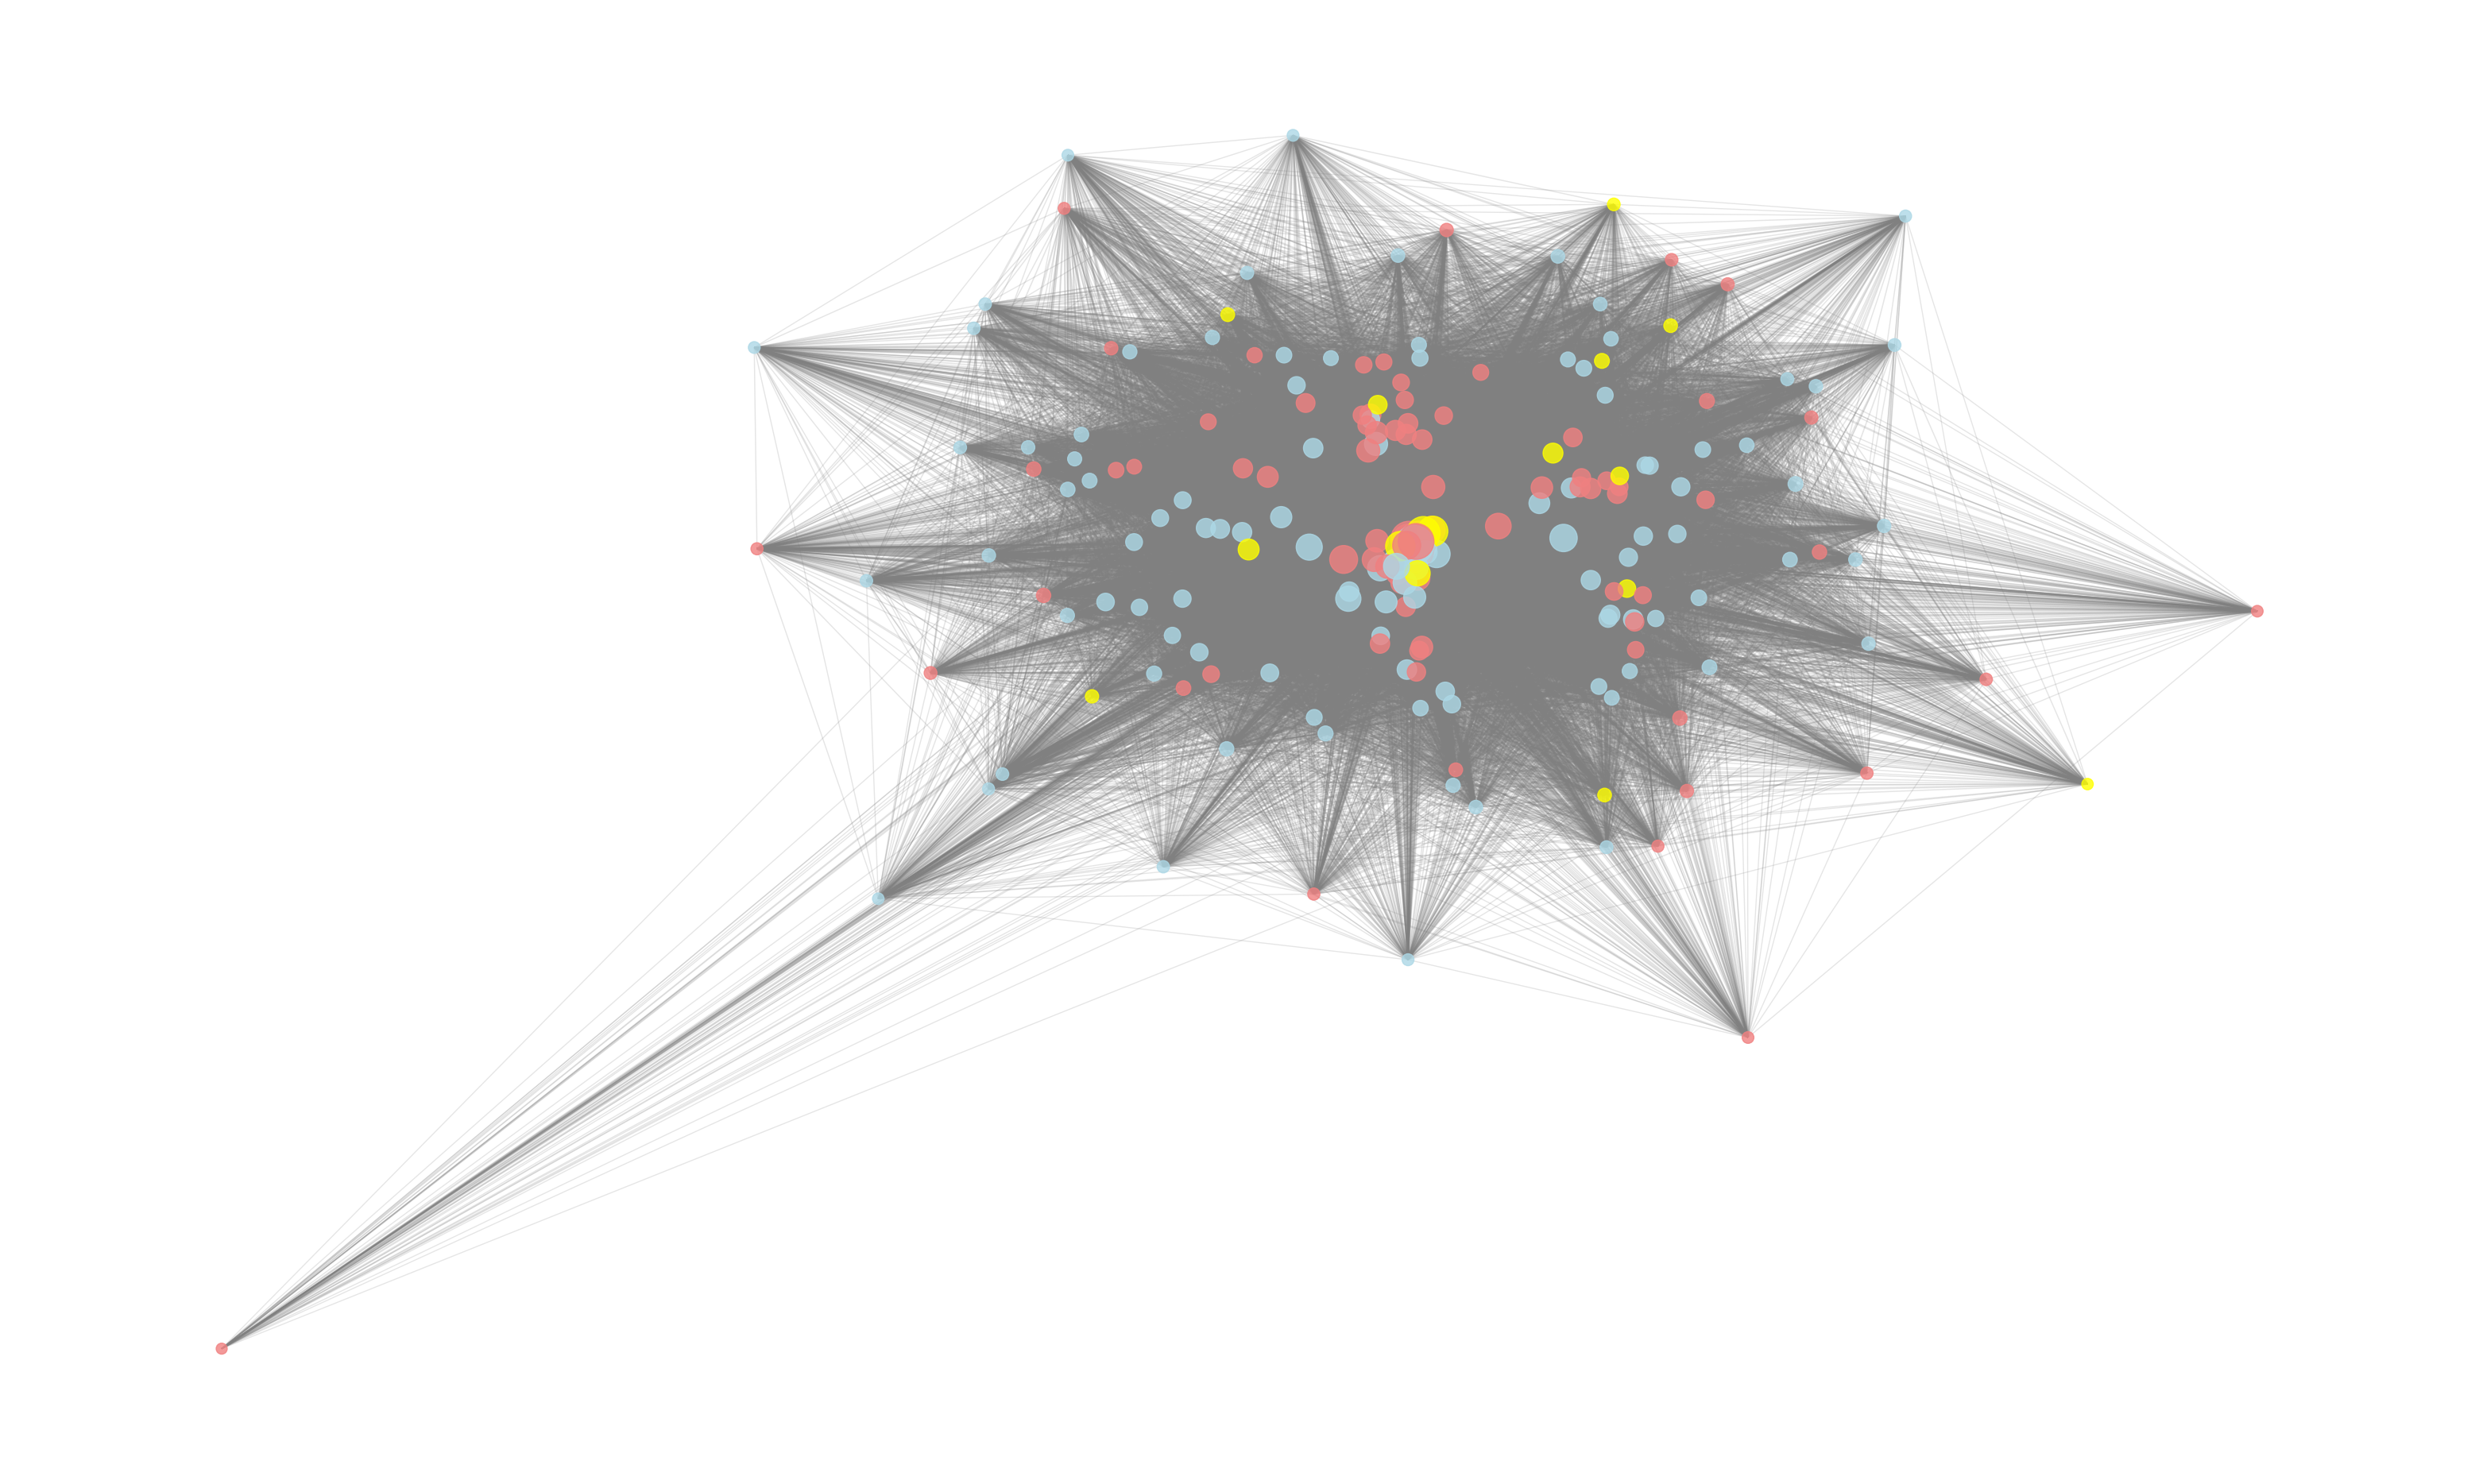

In [ ]:
#pos_draw = nx.drawing.layout.kamada_kawai_layout(G2, weight='weight')
pos_draw = nx.drawing.layout.fruchterman_reingold_layout(G2, weight='weight', iterations=200)

pos_draw = drawGraph(G2,
                    pos=pos_draw,
                    node_size='degree', # size by # of mentions
                    #labels = dict([(u, G2.nodes[u]['label']) for u in G2.nodes()]), # uncomment to see MP names
                    node_color=[gov_colors[e['group']] for _,e in G2.nodes(data=True)])


### Clustering

In [ ]:
dct = nx.clustering(G2, weight='weight')
set_stats_and_ranks(G2, dct.items(), 'clustering')

arr = sorted(dct.items(), key=lambda x: x[-1], reverse=True)
for v,u in arr[:15]:
  print(u, G2.nodes[v])

0.11417041725153611 {'bipartite': 0, 'label': 'Heinonen, Timo (1975-)', 'color': '#00587C', 'group': 'http://ldf.fi/semparl/groups/Q304191', 'id': 'http://ldf.fi/semparl/people/p967', 'date': datetime.date(2007, 3, 21), 'degree': 1044, 'degree2': 26253, 'clustering': 0.11417041725153611}
0.10901938453924712 {'bipartite': 0, 'label': 'Myllykoski, Jari (1959-)', 'color': '#BF1E24', 'group': 'http://ldf.fi/semparl/groups/Q385927', 'id': 'http://ldf.fi/semparl/people/p1154', 'date': datetime.date(2011, 4, 20), 'degree': 842, 'degree2': 24211, 'clustering': 0.10901938453924712}
0.10806182443288348 {'bipartite': 0, 'label': 'Hoskonen, Hannu (1957-)', 'color': '#01954B', 'group': 'http://ldf.fi/semparl/groups/Q506591', 'id': 'http://ldf.fi/semparl/people/p797', 'date': datetime.date(2003, 3, 19), 'degree': 830, 'degree2': 24019, 'clustering': 0.10806182443288348}
0.10275199640762472 {'bipartite': 0, 'label': 'Meri, Leena (1968-)', 'color': '#FFDE55', 'group': 'http://ldf.fi/semparl/groups/Q63

### Betweenness

In [ ]:
dct = nx.betweenness_centrality(G2)
set_stats_and_ranks(G2, dct.items(), 'betweenness')

arr =sorted(dct.items(), key=lambda x: x[-1], reverse=True)
for v,u in arr[:15]:
  print(u, G2.nodes[v])

0.00010060105695176559 {'bipartite': 0, 'label': 'Terho, Sampo (1977-)', 'color': '#FF5500', 'group': 'http://ldf.fi/semparl/groups/Q30337076', 'id': 'http://ldf.fi/semparl/people/p1347', 'date': datetime.date(2017, 6, 13), 'degree': 113, 'degree2': 6346, 'clustering': 0.045422229135841465, 'betweenness': 0.00010060105695176559}
0.00010060105695176559 {'bipartite': 0, 'label': 'Andersson, Li (1987-)', 'color': '#BF1E24', 'group': 'http://ldf.fi/semparl/groups/Q385927', 'id': 'http://ldf.fi/semparl/people/p1310', 'date': datetime.date(2015, 4, 22), 'degree': 569, 'degree2': 18073, 'clustering': 0.08931949339588302, 'betweenness': 0.00010060105695176559}
0.00010060105695176559 {'bipartite': 0, 'label': 'Hassi, Satu (1951-)', 'color': '#61BF1A', 'group': 'http://ldf.fi/semparl/groups/Q196695', 'id': 'http://ldf.fi/semparl/people/p363', 'date': datetime.date(1991, 3, 22), 'degree': 372, 'degree2': 14580, 'clustering': 0.07898520695532127, 'betweenness': 0.00010060105695176559}
0.0001006010

### Closeness

In [ ]:
dct = nx.closeness_centrality(G2)
set_stats_and_ranks(G2, dct.items(), 'clustering')

arr = sorted(dct.items(), key=lambda x: x[-1], reverse=True)
for v,u in arr[:15]:
  print(u, G2.nodes[v])

1.0 {'bipartite': 0, 'label': 'Terho, Sampo (1977-)', 'color': '#FF5500', 'group': 'http://ldf.fi/semparl/groups/Q30337076', 'id': 'http://ldf.fi/semparl/people/p1347', 'date': datetime.date(2017, 6, 13), 'degree': 113, 'degree2': 6346, 'clustering': 1.0, 'betweenness': 0.00010060105695176559}
1.0 {'bipartite': 0, 'label': 'Andersson, Li (1987-)', 'color': '#BF1E24', 'group': 'http://ldf.fi/semparl/groups/Q385927', 'id': 'http://ldf.fi/semparl/people/p1310', 'date': datetime.date(2015, 4, 22), 'degree': 569, 'degree2': 18073, 'clustering': 1.0, 'betweenness': 0.00010060105695176559}
1.0 {'bipartite': 0, 'label': 'Hassi, Satu (1951-)', 'color': '#61BF1A', 'group': 'http://ldf.fi/semparl/groups/Q196695', 'id': 'http://ldf.fi/semparl/people/p363', 'date': datetime.date(1991, 3, 22), 'degree': 372, 'degree2': 14580, 'clustering': 1.0, 'betweenness': 0.00010060105695176559}
1.0 {'bipartite': 0, 'label': 'Honkonen, Petri (1987-)', 'color': '#01954B', 'group': 'http://ldf.fi/semparl/groups/Q5

### Core number

In [ ]:

dct = nx.core_number(G2)
set_stats_and_ranks(G2, dct.items(), 'core_number')

arr = sorted(dct.items(), key=lambda x: x[-1], reverse=True)
for v,u in arr[:15]:
  print(u, G2.nodes[v])


200 {'bipartite': 0, 'label': 'Terho, Sampo (1977-)', 'color': '#FF5500', 'group': 'http://ldf.fi/semparl/groups/Q30337076', 'id': 'http://ldf.fi/semparl/people/p1347', 'date': datetime.date(2017, 6, 13), 'degree': 113, 'degree2': 6346, 'clustering': 1.0, 'betweenness': 0.00010060105695176559, 'core_number': 200}
200 {'bipartite': 0, 'label': 'Puska, Pekka (1945-)', 'color': '#01954B', 'group': 'http://ldf.fi/semparl/groups/Q506591', 'id': 'http://ldf.fi/semparl/people/p242', 'date': datetime.date(1987, 3, 21), 'degree': 54, 'degree2': 4095, 'clustering': 0.995260663507109, 'betweenness': 2.1868526875565367e-05, 'core_number': 200}
200 {'bipartite': 0, 'label': 'Andersson, Li (1987-)', 'color': '#BF1E24', 'group': 'http://ldf.fi/semparl/groups/Q385927', 'id': 'http://ldf.fi/semparl/people/p1310', 'date': datetime.date(2015, 4, 22), 'degree': 569, 'degree2': 18073, 'clustering': 1.0, 'betweenness': 0.00010060105695176559, 'core_number': 200}
200 {'bipartite': 0, 'label': 'Puumala, Tuomo

### Eigenvector centrality

In [ ]:
dct = nx.eigenvector_centrality(G2, max_iter=500, weight='weight')
set_stats_and_ranks(G2, dct.items(), 'eigenvector')

arr = sorted(dct.items(), key=lambda x: x[-1], reverse=True)
for v,u in arr[:30]:
  print(u, G2.nodes[v])

0.1922688690921074 {'bipartite': 0, 'label': 'Heinonen, Timo (1975-)', 'color': '#00587C', 'group': 'http://ldf.fi/semparl/groups/Q304191', 'id': 'http://ldf.fi/semparl/people/p967', 'date': datetime.date(2007, 3, 21), 'degree': 1044, 'degree2': 26253, 'clustering': 1.0, 'betweenness': 0.00010060105695176559, 'core_number': 200, 'eigenvector': 0.1922688690921074}
0.17456664816575557 {'bipartite': 0, 'label': 'Hoskonen, Hannu (1957-)', 'color': '#01954B', 'group': 'http://ldf.fi/semparl/groups/Q506591', 'id': 'http://ldf.fi/semparl/people/p797', 'date': datetime.date(2003, 3, 19), 'degree': 830, 'degree2': 24019, 'clustering': 1.0, 'betweenness': 0.00010060105695176559, 'core_number': 200, 'eigenvector': 0.17456664816575557}
0.1740076640301939 {'bipartite': 0, 'label': 'Myllykoski, Jari (1959-)', 'color': '#BF1E24', 'group': 'http://ldf.fi/semparl/groups/Q385927', 'id': 'http://ldf.fi/semparl/people/p1154', 'date': datetime.date(2011, 4, 20), 'degree': 842, 'degree2': 24211, 'clustering

### Node clique number

In [ ]:
dct = nx.node_clique_number(G2.to_undirected())
set_stats_and_ranks(G2, dct.items(), 'clique_number')

arr = sorted(dct.items(), key=lambda x: x[-1], reverse=True)
for v,u in arr[:15]:
  print(u, G2.nodes[v])

195 {'bipartite': 0, 'label': 'Terho, Sampo (1977-)', 'color': '#FF5500', 'group': 'http://ldf.fi/semparl/groups/Q30337076', 'id': 'http://ldf.fi/semparl/people/p1347', 'date': datetime.date(2017, 6, 13), 'degree': 113, 'degree2': 6346, 'clustering': 1.0, 'betweenness': 0.00010060105695176559, 'core_number': 200, 'eigenvector': 0.04299477183276664, 'clique_number': 195}
195 {'bipartite': 0, 'label': 'Andersson, Li (1987-)', 'color': '#BF1E24', 'group': 'http://ldf.fi/semparl/groups/Q385927', 'id': 'http://ldf.fi/semparl/people/p1310', 'date': datetime.date(2015, 4, 22), 'degree': 569, 'degree2': 18073, 'clustering': 1.0, 'betweenness': 0.00010060105695176559, 'core_number': 200, 'eigenvector': 0.1329598414178356, 'clique_number': 195}
195 {'bipartite': 0, 'label': 'Hassi, Satu (1951-)', 'color': '#61BF1A', 'group': 'http://ldf.fi/semparl/groups/Q196695', 'id': 'http://ldf.fi/semparl/people/p363', 'date': datetime.date(1991, 3, 22), 'degree': 372, 'degree2': 14580, 'clustering': 1.0, 'b

In [ ]:
coms = algorithms.louvain(G2, resolution=1., randomize=False)
print(coms)

In [ ]:
lgroups = []
for c in coms.communities:
  print("Group")
  lgroups1 = []
  for id in c:
    print(G2.nodes[id]['label'])
    lgroups1.append(G2.nodes[id]['label'])
  lgroups.append(lgroups1)
  print()

Group
Puska, Pekka (1945-)
Filatov, Tarja (1963-)
Tolvanen, Kari (1961-)
Nurminen, Ilmari (1991-)
Huovinen, Susanna (1972-)
Keränen, Niilo (1950-)
Tanus, Sari (1964-)
Biaudet, Eva (1961-)
Nylander, Mikaela (1970-)
Mattila, Pirkko (1964-)
Razmyar, Nasima (1984-)
Vahasalo, Raija (1961-)
Heikkinen, Hannakaisa (1974-)
Häkkänen, Antti (1985-)
Paloniemi, Aila (1956-)
Lauslahti, Sanna (1966-)
Talja, Martti (1951-)
Räsänen, Joona (1987-)
Sarkomaa, Sari (1965-)
Mäkipää, Lea (1947-)
Tuomioja, Erkki (1946-)
Immonen, Olli (1986-)
Saarikko, Annika (1983-)
Mattila, Hanna-Leena (1968-)
Kauma, Pia (1966-)
Salonen, Kristiina (1977-)
Ronkainen, Jari (1972-)
Raatikainen, Mika (1961-)
Yanar, Ozan (1987-)
Talvitie, Mari-Leena (1980-)
Torvinen, Matti (1957-)
Haglund, Carl (1979-)
Sirén, Saara-Sofia (1986-)
Vehviläinen, Anu (1963-)
Packalén, Tom (1969-)
Tolppanen, Maria (1952-)
Rehula, Juha (1963-)
Marin, Sanna (1985-)
Vikman, Sofia (1983-)
Kiljunen, Anneli (1957-)
Risikko, Paula (1960-)
Virolainen, Anne-Mar

### Co-citation analysis

#### MDS

In [ ]:
node_labels = [d['label'] for _,d in G2.nodes(data=True)]
C = nx.adjacency_matrix(G2, weight='weight')
C = np.asarray(C.todense())
df = pd.DataFrame(C, columns=node_labels, index=node_labels)
df.to_csv('raw_comentions_all.csv')
#idx = df.sum(axis=1).head(30).index
C2 = df.loc[G2_50_labels,G2_50_labels].to_numpy(dtype='float64')
df3 = pd.DataFrame(C2.copy(), columns=G2_50_labels, index=G2_50_labels)
#diagonal = np.mean(C2, axis=0)
#np.fill_diagonal(C2,diagonal)
np.fill_diagonal(C2,np.nan)
diagonal = np.nanmean(C2, axis=0)
np.fill_diagonal(C2,diagonal)
df3

Viitanen, Pia (1967-)  \
Viitanen, Pia (1967-)                               0.0   
Heinonen, Timo (1975-)                            516.0   
Zyskowicz, Ben (1954-)                            416.0   
Myllykoski, Jari (1959-)                          433.0   
Hoskonen, Hannu (1957-)                           413.0   
Lindtman, Antti (1982-)                           640.0   
Heinäluoma, Eero (1955-)                          566.0   
Harakka, Timo (1962-)                             492.0   
Meri, Leena (1968-)                               372.0   
Elo, Simon (1986-)                                378.0   
Arhinmäki, Paavo (1976-)                          419.0   
Andersson, Li (1987-)                             384.0   
Savio, Sami (1975-)                               261.0   
Lindström, Jari (1965-)                           256.0   
Kankaanniemi, Toimi (1950-)                       328.0   
Aalto, Touko (1984-)                              350.0   
Rinne, Antti (1962-)                              348.0   
Niinistö, Jussi (1970-)                           163.0   
Tiilikainen, Kimmo (1966-)                        192.0   
Essayah, Sari (1967-)                             244.0   
Sipilä, Juha (1961-)                              235.0   
Saarikko, Annika (1983-)                          170.0   
Ala-Nissilä, Olavi (1949-)                        285.0   
Hassi, Satu (1951-)                               170.0   
Orpo, Petteri (1969-)                             226.0   
Soini, Timo (1962-)                               153.0   
Elomaa, Ritva (1955-)                             189.0   
Kari, Mika (1967-)                                194.0   
Mykkänen, Kai (1979-)                             153.0   
Kiuru, Krista (1974-)                             241.0   
Mäkelä, Jani (1976-)                              164.0   
Kiuru, Pauli (1962-)                              162.0   
Räsänen, Päivi (1959-)                            160.0   
Gustafsson, Jukka (1947-)                         202.0   
Niikko, Mika (1967-)                              169.0   
Laukkanen, Antero (1958-)                         160.0   
Kurvinen, Antti (1986-)                           169.0   
Mattila, Pirkko (1964-)                           144.0   
Mäkisalo-Ropponen, Merja (1958-)                  147.0   
Turunen, Kaj (1960-)                              164.0   
Marin, Sanna (1985-)                              177.0   
Kiljunen, Anneli (1957-)                          139.0   
Pakkanen, Markku (1960-)                          142.0   
Rehn, Olli (1962-)                                160.0   
Niinistö, Ville (1976-)                           195.0   
Mikkonen, Krista (1972-)                          130.0   
Ojala-Niemelä, Johanna (1974-)                    168.0   
Vehviläinen, Anu (1963-)                          143.0   
Uotila, Kari (1955-)                              180.0   
Tanus, Sari (1964-)                                96.0   

                                  Heinonen, Timo (1975-)  \
Viitanen, Pia (1967-)                              516.0   
Heinonen, Timo (1975-)                               0.0   
Zyskowicz, Ben (1954-)                             508.0   
Myllykoski, Jari (1959-)                           466.0   
Hoskonen, Hannu (1957-)                            531.0   
Lindtman, Antti (1982-)                            483.0   
Heinäluoma, Eero (1955-)                           489.0   
Harakka, Timo (1962-)                              445.0   
Meri, Leena (1968-)                                472.0   
Elo, Simon (1986-)                                 448.0   
Arhinmäki, Paavo (1976-)                           320.0   
Andersson, Li (1987-)                              373.0   
Savio, Sami (1975-)                                304.0   
Lindström, Jari (1965-)                            340.0   
Kankaanniemi, Toimi (1950-)                        369.0   
Aalto, Touko (1984-)                               316.0   
Rinn

In [ ]:
G3 = nx.from_pandas_adjacency(df3)
print(G3.edges(data=True))
print(G3.nodes())

coms = algorithms.louvain(G3, resolution=1., randomize=False)
print(coms)

lgroups = []
for c in coms.communities:
  print("Group")
  lgroups1 = []
  for id in c:
    print(id)
    lgroups1.append(id)
  lgroups.append(lgroups1)
  print()

[('Viitanen, Pia (1967-)', 'Heinonen, Timo (1975-)', {'weight': 516.0}), ('Viitanen, Pia (1967-)', 'Zyskowicz, Ben (1954-)', {'weight': 416.0}), ('Viitanen, Pia (1967-)', 'Myllykoski, Jari (1959-)', {'weight': 433.0}), ('Viitanen, Pia (1967-)', 'Hoskonen, Hannu (1957-)', {'weight': 413.0}), ('Viitanen, Pia (1967-)', 'Lindtman, Antti (1982-)', {'weight': 640.0}), ('Viitanen, Pia (1967-)', 'Heinäluoma, Eero (1955-)', {'weight': 566.0}), ('Viitanen, Pia (1967-)', 'Harakka, Timo (1962-)', {'weight': 492.0}), ('Viitanen, Pia (1967-)', 'Meri, Leena (1968-)', {'weight': 372.0}), ('Viitanen, Pia (1967-)', 'Elo, Simon (1986-)', {'weight': 378.0}), ('Viitanen, Pia (1967-)', 'Arhinmäki, Paavo (1976-)', {'weight': 419.0}), ('Viitanen, Pia (1967-)', 'Andersson, Li (1987-)', {'weight': 384.0}), ('Viitanen, Pia (1967-)', 'Savio, Sami (1975-)', {'weight': 261.0}), ('Viitanen, Pia (1967-)', 'Lindström, Jari (1965-)', {'weight': 256.0}), ('Viitanen, Pia (1967-)', 'Kankaanniemi, Toimi (1950-)', {'weight'

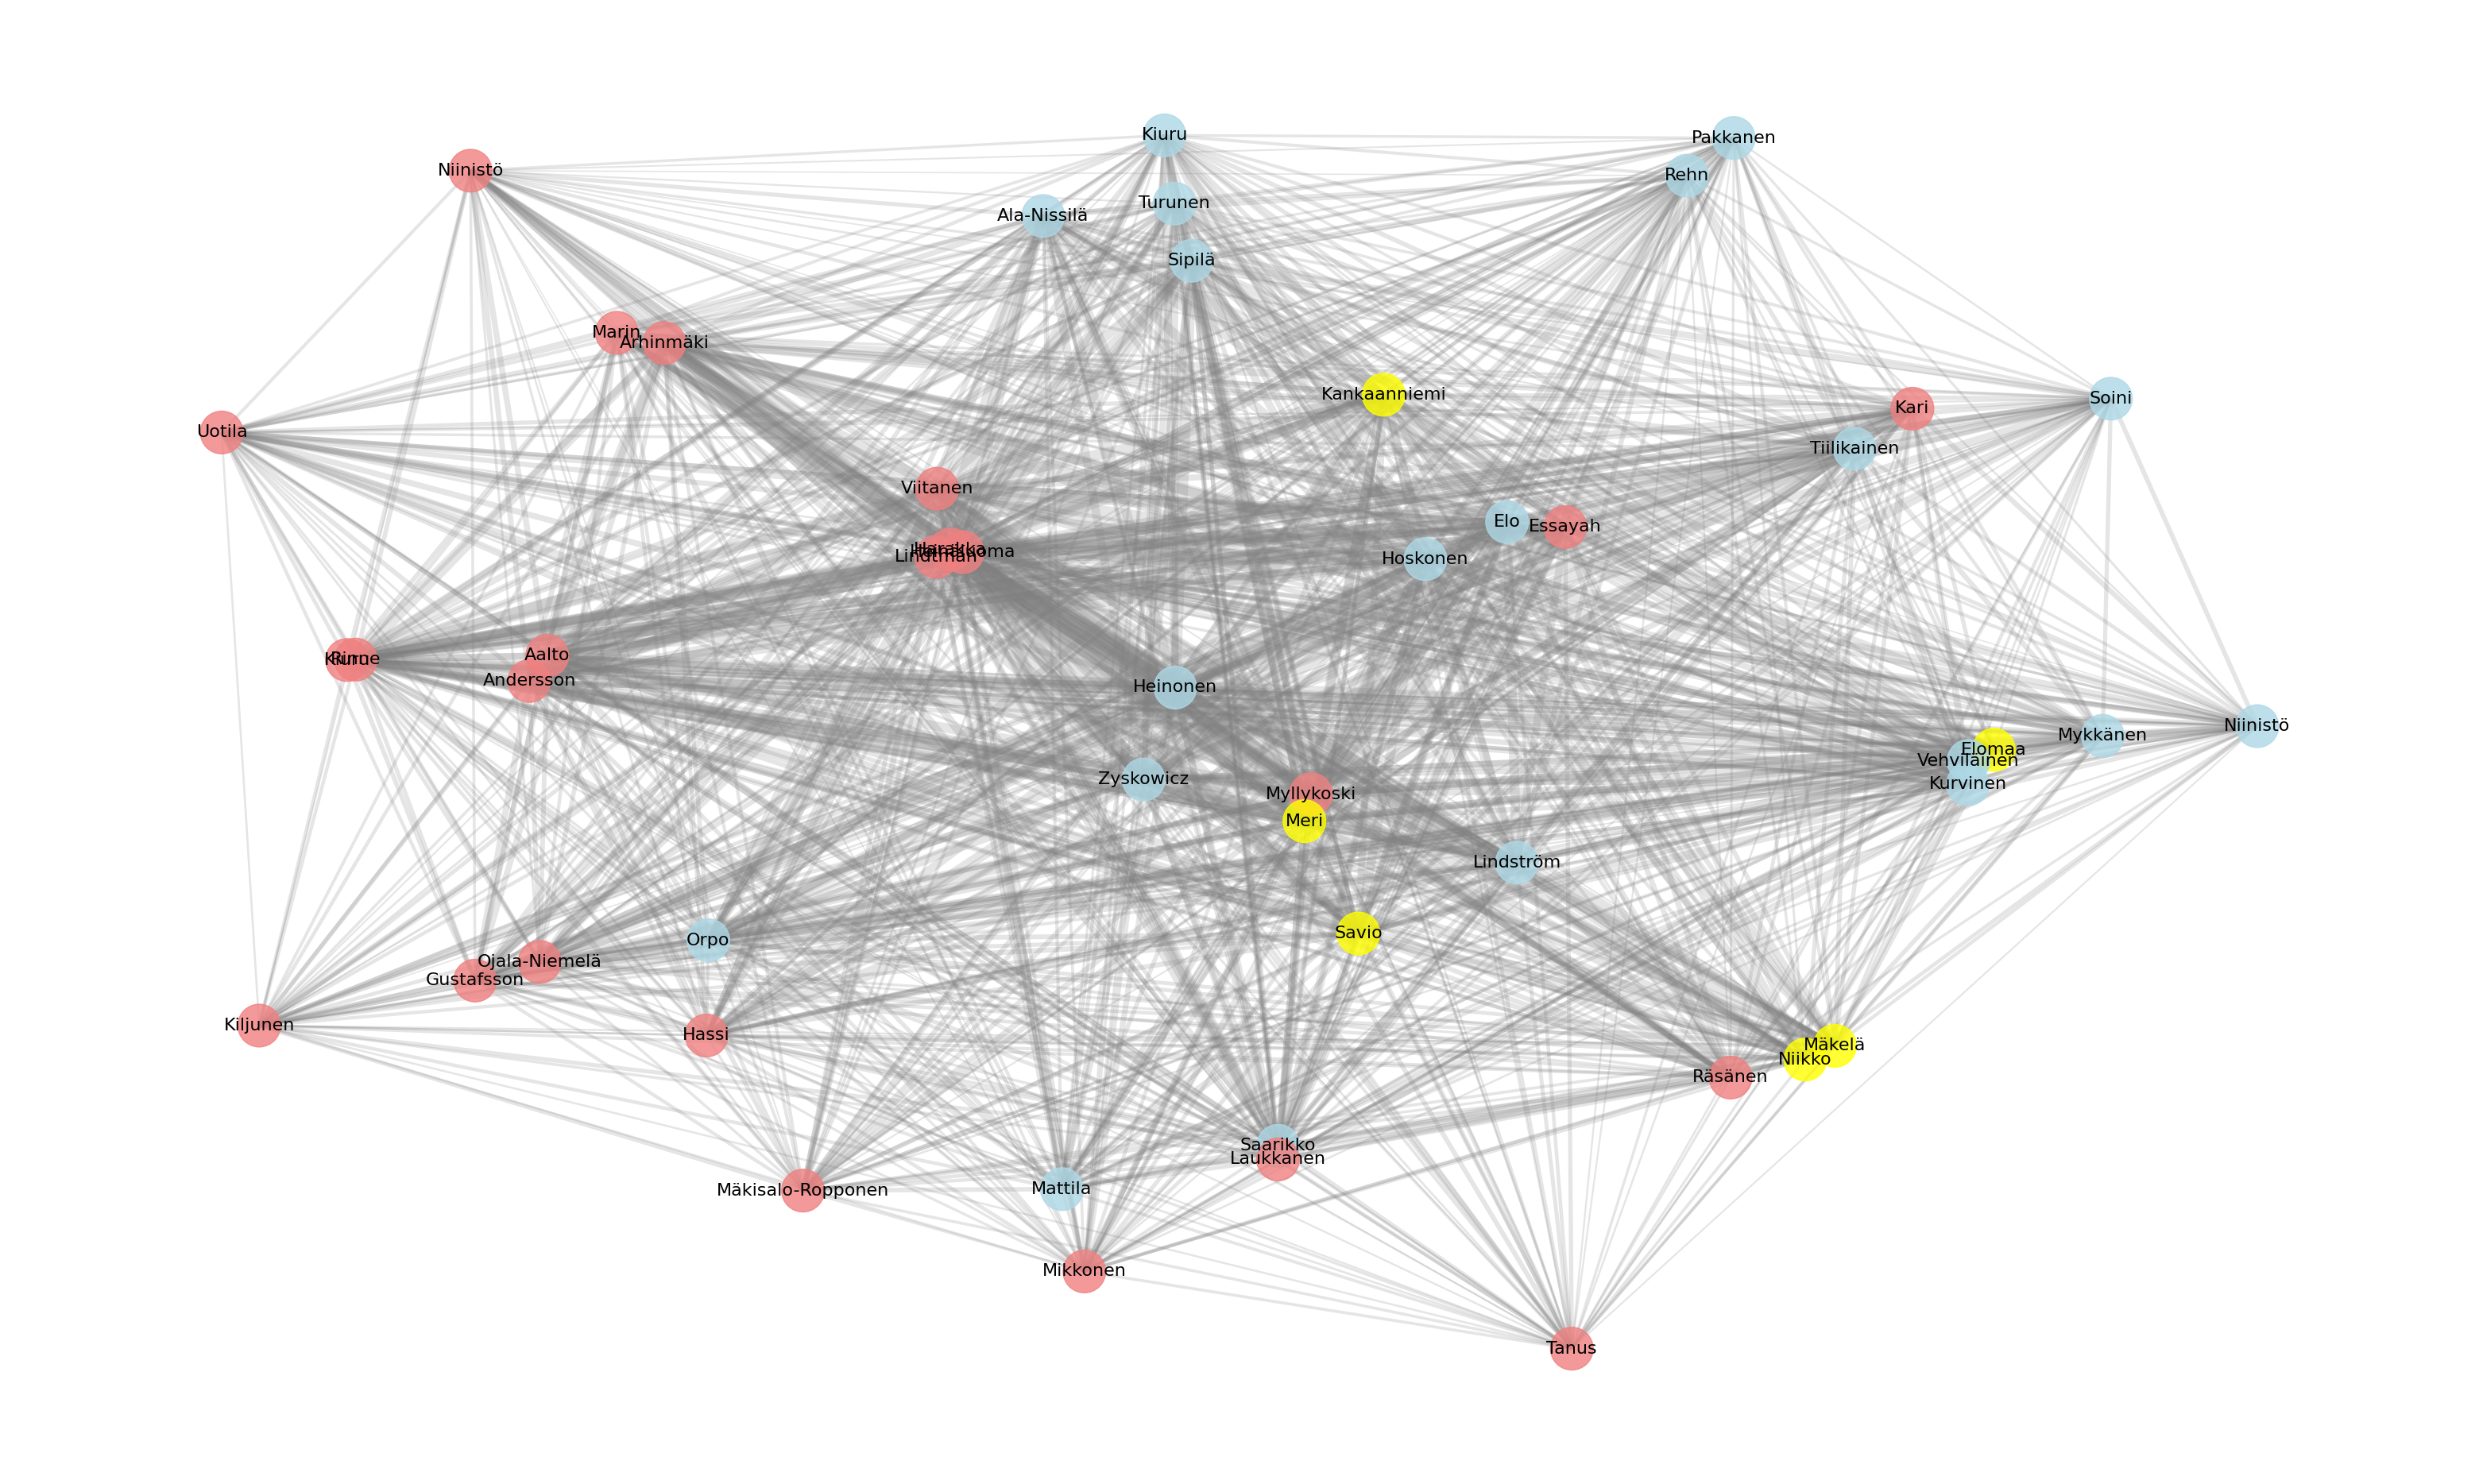

In [ ]:
#pos_draw = nx.drawing.layout.kamada_kawai_layout(G2, weight='weight')
pos_draw = nx.drawing.layout.fruchterman_reingold_layout(G3, weight='weight', iterations=200)

g3_colors = [gov_colors[G2.nodes[n]['group']] for n in G2_50_ids]
g3_labels = dict([(G2.nodes[u]['label'], G2.nodes[u]['label'].split(" ")[0][:-1]) for u in G2_50_ids])
pos_draw = drawGraph(G3,
                    pos=pos_draw,
                    node_size='degree', # size by # of mentions
                    labels = g3_labels, # uncomment to see MP names
                    node_color=g3_colors )


In [ ]:
embedding = MDS(random_state=3, n_components=2, metric=True)
#C_transformed = embedding.fit_transform(np.corrcoef(C2))
C_transformed = embedding.fit_transform(pairwise.cosine_similarity(C2))
print("Stress:", embedding.stress_)

d = pairwise.euclidean_distances(embedding.embedding_)
print(0.5*np.sum((d-embedding.dissimilarity_matrix_)**2))

## Kruskal's stress
stress1 = np.sqrt(embedding.stress_ / (0.5 * np.sum(embedding.dissimilarity_matrix_**2)))
print("Kruskal's Stress :", stress1)


Stress: 0.2535588550123828
0.25060270794358086
Kruskal's Stress : 0.10444988499532012


In [ ]:
R = np.corrcoef(pairwise.euclidean_distances(embedding.embedding_).flatten(), embedding.dissimilarity_matrix_.flatten())[0,1]
print("R-squared", R*R)

R-squared 0.9706081282002144


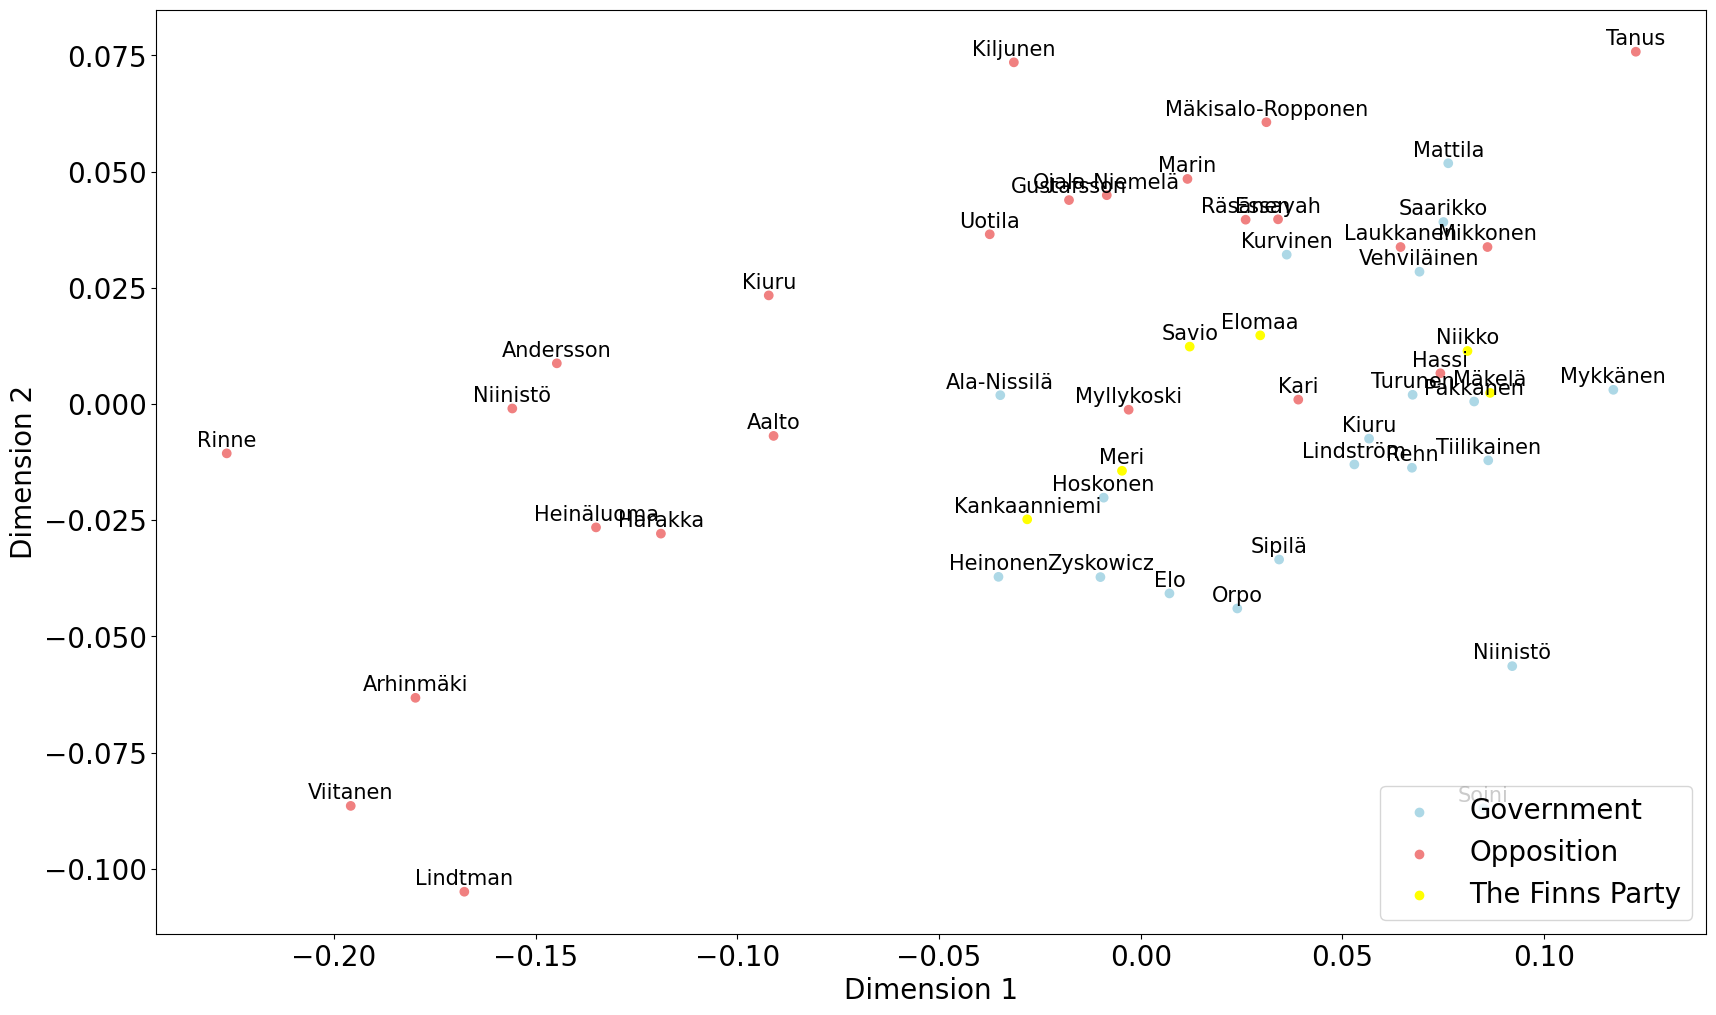

In [ ]:
fig = plt.figure(figsize=[20.0, 12.0])
ax = fig.add_subplot(111)


ax.scatter(C_transformed[:,0], C_transformed[:,1], c=[gov_colors[G.nodes[n]['group']] for n in G2_50_ids])

names = G2_50_labels #[d['label'].split(" ")[0][:-1] for _,d in G2.nodes(data=True)]
for x,y,i in zip(C_transformed[:,0], C_transformed[:,1], range(C_transformed.shape[0])):
    ax.annotate(names[i].split(" ")[0][:-1], # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center',
                 fontsize=15) # horizontal alignment can be left, right or center

G2_50_parties = set([G.nodes[n]['group'] for n in G2_50_ids])

#for p in party_colors:
#  if p in G2_50_parties:
    #print(abbreviations[p])
#    plt.scatter([],[], c=party_colors[p], label=abbreviations[p])
plt.scatter([],[], c='lightblue', label='Government')
plt.scatter([],[], c='lightcoral', label='Opposition')
plt.scatter([],[], c='yellow', label='The Finns Party')




ax.legend(prop={'size': 20},loc='lower right')#, bbox_to_anchor=(1, 0.5))
#plt.xlim([-0.14,0.18])
#plt.ylim([-0.32,0.25])
plt.xlabel('Dimension 1', fontsize=20)
plt.ylabel('Dimension 2', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.title('', fontsize=30)
plt.show()

#### Clustering

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

In [ ]:
correlations = pairwise.cosine_similarity(C2) #np.corrcoef(C, rowvar=False)
k = 3

In [ ]:
kmeans = KMeans(n_clusters=k).fit(correlations)
clabels = kmeans.labels_

In [ ]:
cgroups = []
persons = np.array(G2.nodes(data=True))
for i in range(k):
  print("Group", i+1)
  cgroups1 = []
  for person in np.array(G2_50_labels)[clabels==i]:
    print(person)
    cgroups1.append(person)
  cgroups.append(cgroups1)
  print()



Group 1
Viitanen, Pia (1967-)
Lindtman, Antti (1982-)
Heinäluoma, Eero (1955-)
Harakka, Timo (1962-)
Arhinmäki, Paavo (1976-)
Andersson, Li (1987-)
Rinne, Antti (1962-)
Niinistö, Ville (1976-)

Group 2
Lindström, Jari (1965-)
Niinistö, Jussi (1970-)
Tiilikainen, Kimmo (1966-)
Essayah, Sari (1967-)
Sipilä, Juha (1961-)
Saarikko, Annika (1983-)
Hassi, Satu (1951-)
Soini, Timo (1962-)
Elomaa, Ritva (1955-)
Kari, Mika (1967-)
Mykkänen, Kai (1979-)
Mäkelä, Jani (1976-)
Kiuru, Pauli (1962-)
Räsänen, Päivi (1959-)
Niikko, Mika (1967-)
Laukkanen, Antero (1958-)
Kurvinen, Antti (1986-)
Mattila, Pirkko (1964-)
Mäkisalo-Ropponen, Merja (1958-)
Turunen, Kaj (1960-)
Pakkanen, Markku (1960-)
Rehn, Olli (1962-)
Mikkonen, Krista (1972-)
Vehviläinen, Anu (1963-)
Tanus, Sari (1964-)

Group 3
Heinonen, Timo (1975-)
Zyskowicz, Ben (1954-)
Myllykoski, Jari (1959-)
Hoskonen, Hannu (1957-)
Meri, Leena (1968-)
Elo, Simon (1986-)
Savio, Sami (1975-)
Kankaanniemi, Toimi (1950-)
Aalto, Touko (1984-)
Ala-Nissilä,

In [ ]:
for g1 in lgroups:
  for g2 in cgroups:
    common_names = len(list(set(g1) & set(g2)))
    print(common_names)

0
23
6
8
0
4
0
2
7


In [ ]:
clustering = AgglomerativeClustering(n_clusters=k).fit(correlations)
clabels = clustering.labels_

In [ ]:
cgroups = []
persons = np.array(G.nodes(data=True))
for i in range(k):
  print("Group", i+1)
  cgroups1 = []
  for person in np.array(G2_50_labels)[clabels==i]:
    print(person)
    cgroups1.append(person)
  cgroups.append(cgroups1)
  print()



Group 1
Viitanen, Pia (1967-)
Lindtman, Antti (1982-)
Heinäluoma, Eero (1955-)
Harakka, Timo (1962-)
Arhinmäki, Paavo (1976-)
Andersson, Li (1987-)
Aalto, Touko (1984-)
Rinne, Antti (1962-)
Kiuru, Krista (1974-)
Niinistö, Ville (1976-)

Group 2
Heinonen, Timo (1975-)
Zyskowicz, Ben (1954-)
Myllykoski, Jari (1959-)
Hoskonen, Hannu (1957-)
Meri, Leena (1968-)
Elo, Simon (1986-)
Savio, Sami (1975-)
Lindström, Jari (1965-)
Kankaanniemi, Toimi (1950-)
Essayah, Sari (1967-)
Sipilä, Juha (1961-)
Ala-Nissilä, Olavi (1949-)
Orpo, Petteri (1969-)
Elomaa, Ritva (1955-)
Kari, Mika (1967-)
Kiuru, Pauli (1962-)
Räsänen, Päivi (1959-)
Gustafsson, Jukka (1947-)
Kurvinen, Antti (1986-)
Marin, Sanna (1985-)
Kiljunen, Anneli (1957-)
Ojala-Niemelä, Johanna (1974-)
Uotila, Kari (1955-)

Group 3
Niinistö, Jussi (1970-)
Tiilikainen, Kimmo (1966-)
Saarikko, Annika (1983-)
Hassi, Satu (1951-)
Soini, Timo (1962-)
Mykkänen, Kai (1979-)
Mäkelä, Jani (1976-)
Niikko, Mika (1967-)
Laukkanen, Antero (1958-)
Mattila, 

In [ ]:
for g1 in lgroups:
  for g2 in cgroups:
    common_names = len(list(set(g1) & set(g2)))
    print(common_names)

0
13
16
10
2
0
0
8
1


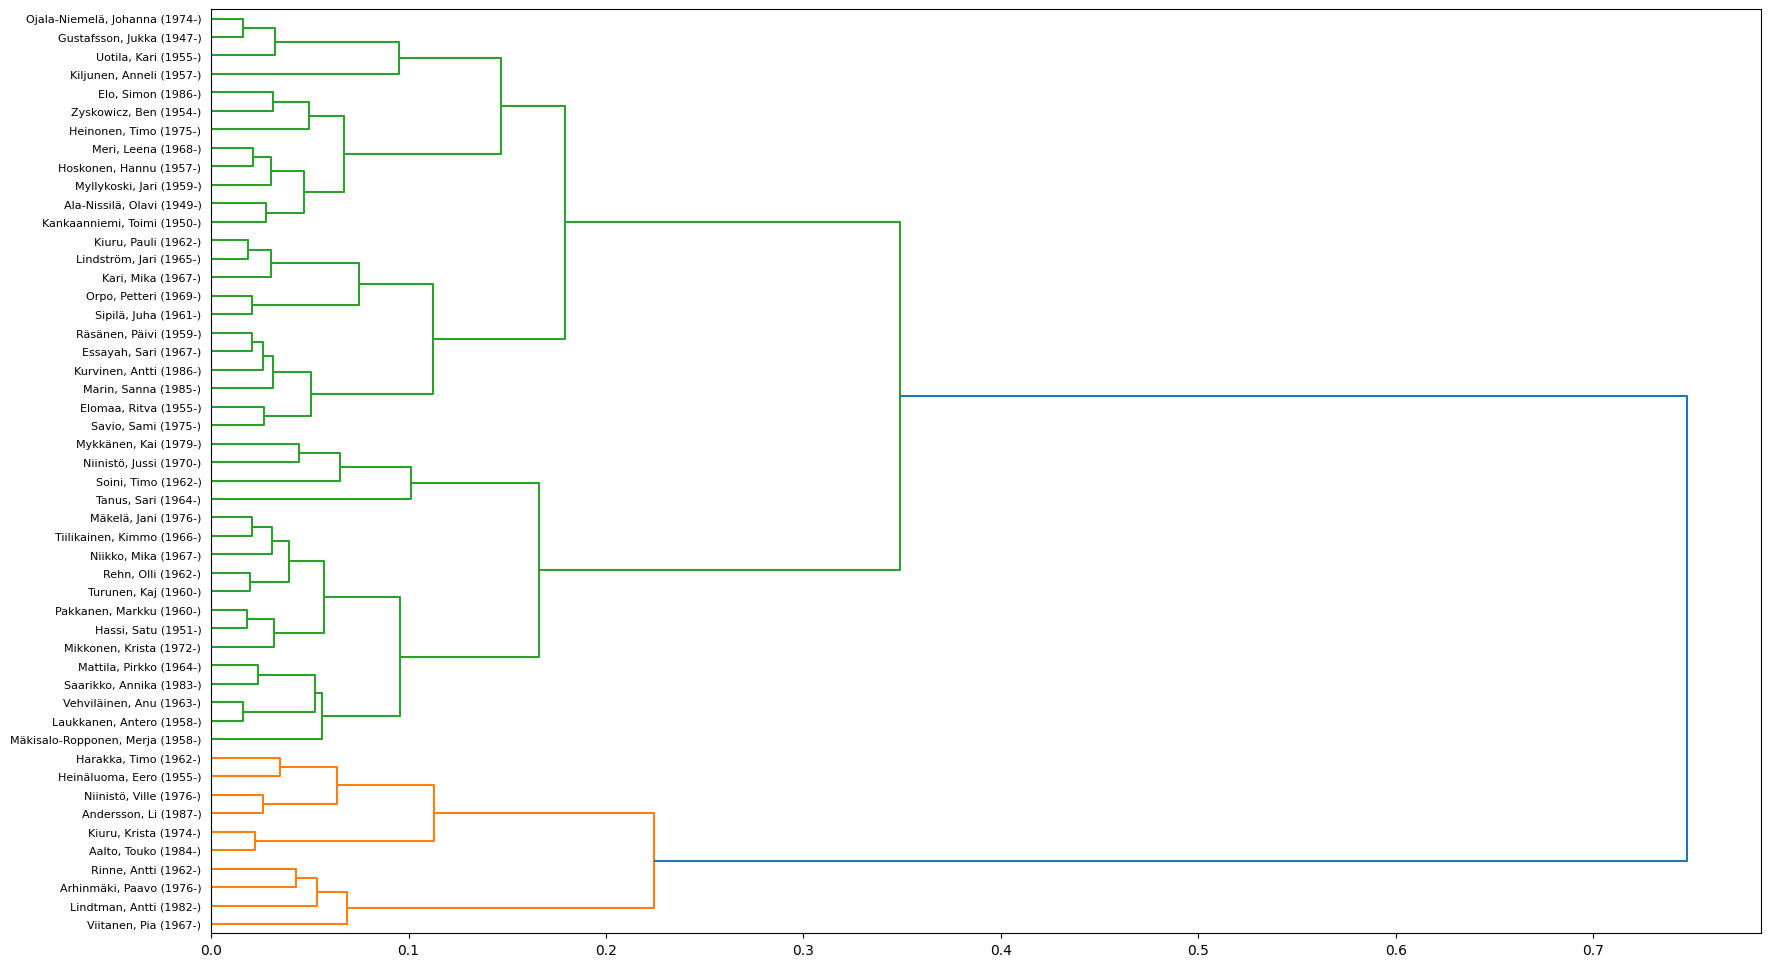

In [ ]:

Z = linkage(correlations, 'ward')

plt.figure(figsize=[20.0, 12.0])

dn = dendrogram(Z, labels=G2_50_labels, orientation='right')

#### Factor analysis

In [ ]:
pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 32.8 MB/s eta 0:00:00
  Created wheel for factor_analyzer: filename=factor_analyzer-0.4.1-py2.py3-none-any.whl size=42014 sha256=7f5569109ca6210b6f9f706f40bbb487354b7762acecbbd6fee032ad681545ab
  Stored in directory: /root/.cache/pip/wheels/c5/94/da/41abe415f64706710726291086a814dd8b9e0dab1c491ef6ed
Successfully built factor_analyzer


In [ ]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

In [ ]:
kmo_all,kmo_model=calculate_kmo(pairwise.cosine_similarity(C2))
kmo_model

0.3195555642931646

In [ ]:
kmo_all

array([0.83974714, 0.14471329, 0.1937201 , 0.28292997, 0.22597055,
       0.29033439, 0.26672361, 0.2822103 , 0.25525206, 0.28871202,
       0.30608504, 0.28626412, 0.3355112 , 0.38910864, 0.15632759,
       0.24748409, 0.32154144, 0.38232403, 0.38092229, 0.37165755,
       0.32850256, 0.37033947, 0.17243916, 0.37960305, 0.28844395,
       0.33794885, 0.35690145, 0.37295117, 0.38270115, 0.22017064,
       0.38460967, 0.37936321, 0.34848817, 0.19643334, 0.38921261,
       0.3767623 , 0.35453468, 0.36607056, 0.31237545, 0.38447635,
       0.30344562, 0.16070578, 0.37518797, 0.37645111, 0.27820838,
       0.37499441, 0.23395797, 0.37850604, 0.15687887, 0.37167349])

In [ ]:
calculate_bartlett_sphericity(pairwise.cosine_similarity(C2))

(nan, nan)

In [ ]:
fa = FactorAnalyzer(n_factors=nn, rotation=None, method='principal')
fa.fit(pairwise.cosine_similarity(C2))

FactorAnalyzer(method='principal', n_factors=50, rotation=None,
               rotation_kwargs={})

In [ ]:
print(np.sum(fa.get_eigenvalues()[0]>1))
factors = np.sum(fa.get_eigenvalues()[0]>1)
fa.get_eigenvalues()[0]

3


array([ 3.12299200e+01,  1.13160757e+01,  5.55717740e+00,  6.28498049e-01,
        2.43895647e-01,  2.04584778e-01,  1.75253292e-01,  1.25626056e-01,
        1.08484151e-01,  9.29783149e-02,  6.97002235e-02,  5.34043872e-02,
        3.85915108e-02,  3.44253029e-02,  2.76744871e-02,  2.13640883e-02,
        1.52925020e-02,  1.09077359e-02,  9.47823090e-03,  8.13893261e-03,
        6.25562397e-03,  5.25217504e-03,  3.37701661e-03,  2.72661759e-03,
        2.57255742e-03,  2.11396856e-03,  1.60881792e-03,  1.19791029e-03,
        7.32893804e-04,  6.63713307e-04,  4.30229508e-04,  3.32536778e-04,
        2.77660008e-04,  2.52964241e-04,  2.01287769e-04,  1.62597746e-04,
        1.21399247e-04,  9.48336076e-05,  5.31756592e-05,  4.45927526e-05,
        1.75268333e-05,  1.55620633e-05,  1.01663486e-05,  8.49556876e-06,
        3.90129488e-06,  7.21258331e-07,  1.83093224e-07,  8.84986623e-08,
        8.01479745e-11, -4.06927086e-16])

In [ ]:
fa = FactorAnalyzer(n_factors=factors, rotation='varimax', method='principal')
fa.fit_transform(np.corrcoef(C2))


array([[ 0.84276488, -0.60297727, -0.80394721],
       [ 0.58287929,  0.39958081, -0.83836813],
       [ 0.51940025,  0.99445043, -0.30658011],
       [ 0.62729789,  0.83515463,  0.05396574],
       [ 0.62614258,  0.93238343, -0.04196621],
       [ 0.78533841, -0.88502231, -1.71031066],
       [ 1.03540494,  0.02273079, -0.6607719 ],
       [ 1.13432669, -0.18534329, -0.43143537],
       [ 0.67151682,  0.97795922,  0.36482008],
       [ 0.26305282,  1.09891427, -0.30975679],
       [ 0.99773025, -1.35908667, -1.40505683],
       [ 1.02487065, -1.18473888, -0.67709772],
       [ 0.45151772,  0.61264128,  1.17311501],
       [-0.2442964 ,  1.13635727,  0.4793463 ],
       [ 0.99053645,  1.1160774 ,  0.07468354],
       [ 1.25692829, -0.5611073 , -0.32594529],
       [ 1.01180237, -1.48033856, -1.42034214],
       [-1.53158876,  0.42611564, -1.41254614],
       [-1.10045148,  0.70164836, -0.33408425],
       [ 0.39174568,  0.50061482,  1.89616439],
       [-0.16095885,  1.11646561, -1.152

In [ ]:
for i, person in enumerate(G2_50_labels):
  print("{:40s} {}".format(person, fa.loadings_.round(2)[i]))

Viitanen, Pia (1967-)                    [ 0.97 -0.06 -0.03]
Heinonen, Timo (1975-)                   [ 0.79  0.49 -0.07]
Zyskowicz, Ben (1954-)                   [ 0.48  0.79 -0.02]
Myllykoski, Jari (1959-)                 [0.63 0.69 0.12]
Hoskonen, Hannu (1957-)                  [0.59 0.74 0.05]
Lindtman, Antti (1982-)                  [ 0.97 -0.08 -0.13]
Heinäluoma, Eero (1955-)                 [ 0.98  0.07 -0.08]
Harakka, Timo (1962-)                    [ 0.99 -0.03 -0.03]
Meri, Leena (1968-)                      [0.53 0.76 0.18]
Elo, Simon (1986-)                       [0.19 0.92 0.05]
Arhinmäki, Paavo (1976-)                 [ 0.97 -0.22 -0.06]
Andersson, Li (1987-)                    [ 0.96 -0.25  0.01]
Savio, Sami (1975-)                      [0.33 0.63 0.55]
Lindström, Jari (1965-)                  [-0.42  0.84  0.27]
Kankaanniemi, Toimi (1950-)              [ 0.77  0.59 -0.01]
Aalto, Touko (1984-)                     [ 0.98 -0.15  0.01]
Rinne, Antti (1962-)                   

In [ ]:
print("Proportional variance:", np.sum(fa.get_factor_variance()[1]))
print(fa.get_factor_variance()[2])
print(fa.get_factor_variance()[0])

Proportional variance: 0.9060143487106225
[0.43311    0.77092577 0.90601435]
[21.65549978 16.89078868  6.75442897]


Proportional variance: [0.43311    0.33781577 0.13508858]
0.4331099956354403


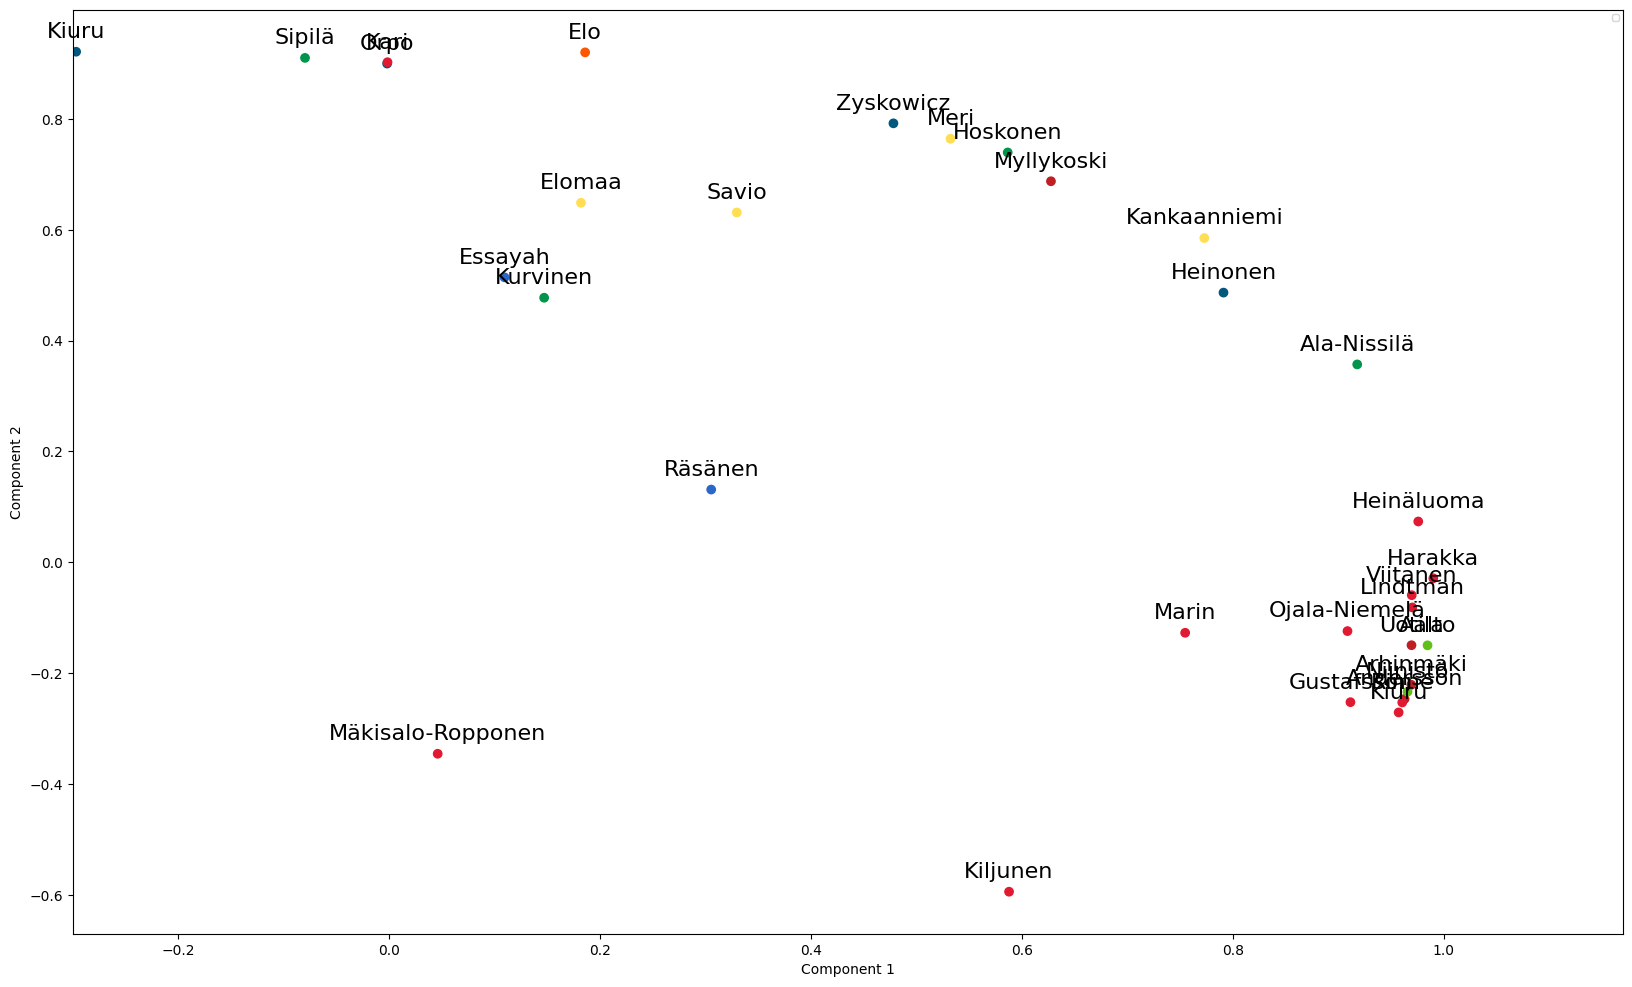

In [ ]:
print("Proportional variance:", fa.get_factor_variance()[1])
print(np.sum(fa.get_factor_variance()[1][0:1]))
xs = fa.loadings_[:,0]
ys = fa.loadings_[:,1]



fig = plt.figure(figsize=[20.0, 12.0])
ax = fig.add_subplot(111)
ax.scatter(xs,ys, color=[G.nodes[n]['color'] for n in G2_50_ids])
for x,y,i in zip(xs, ys, range(xs.shape[0])):
    ax.annotate(G2_50_labels[i].split(" ")[0][:-1],
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=16)

plt.legend(prop={'size': 6})
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.xlim([-0.3,1.17])
#plt.ylim([-0.45,0.35])
plt.show()

3
3
53
53
211
[]


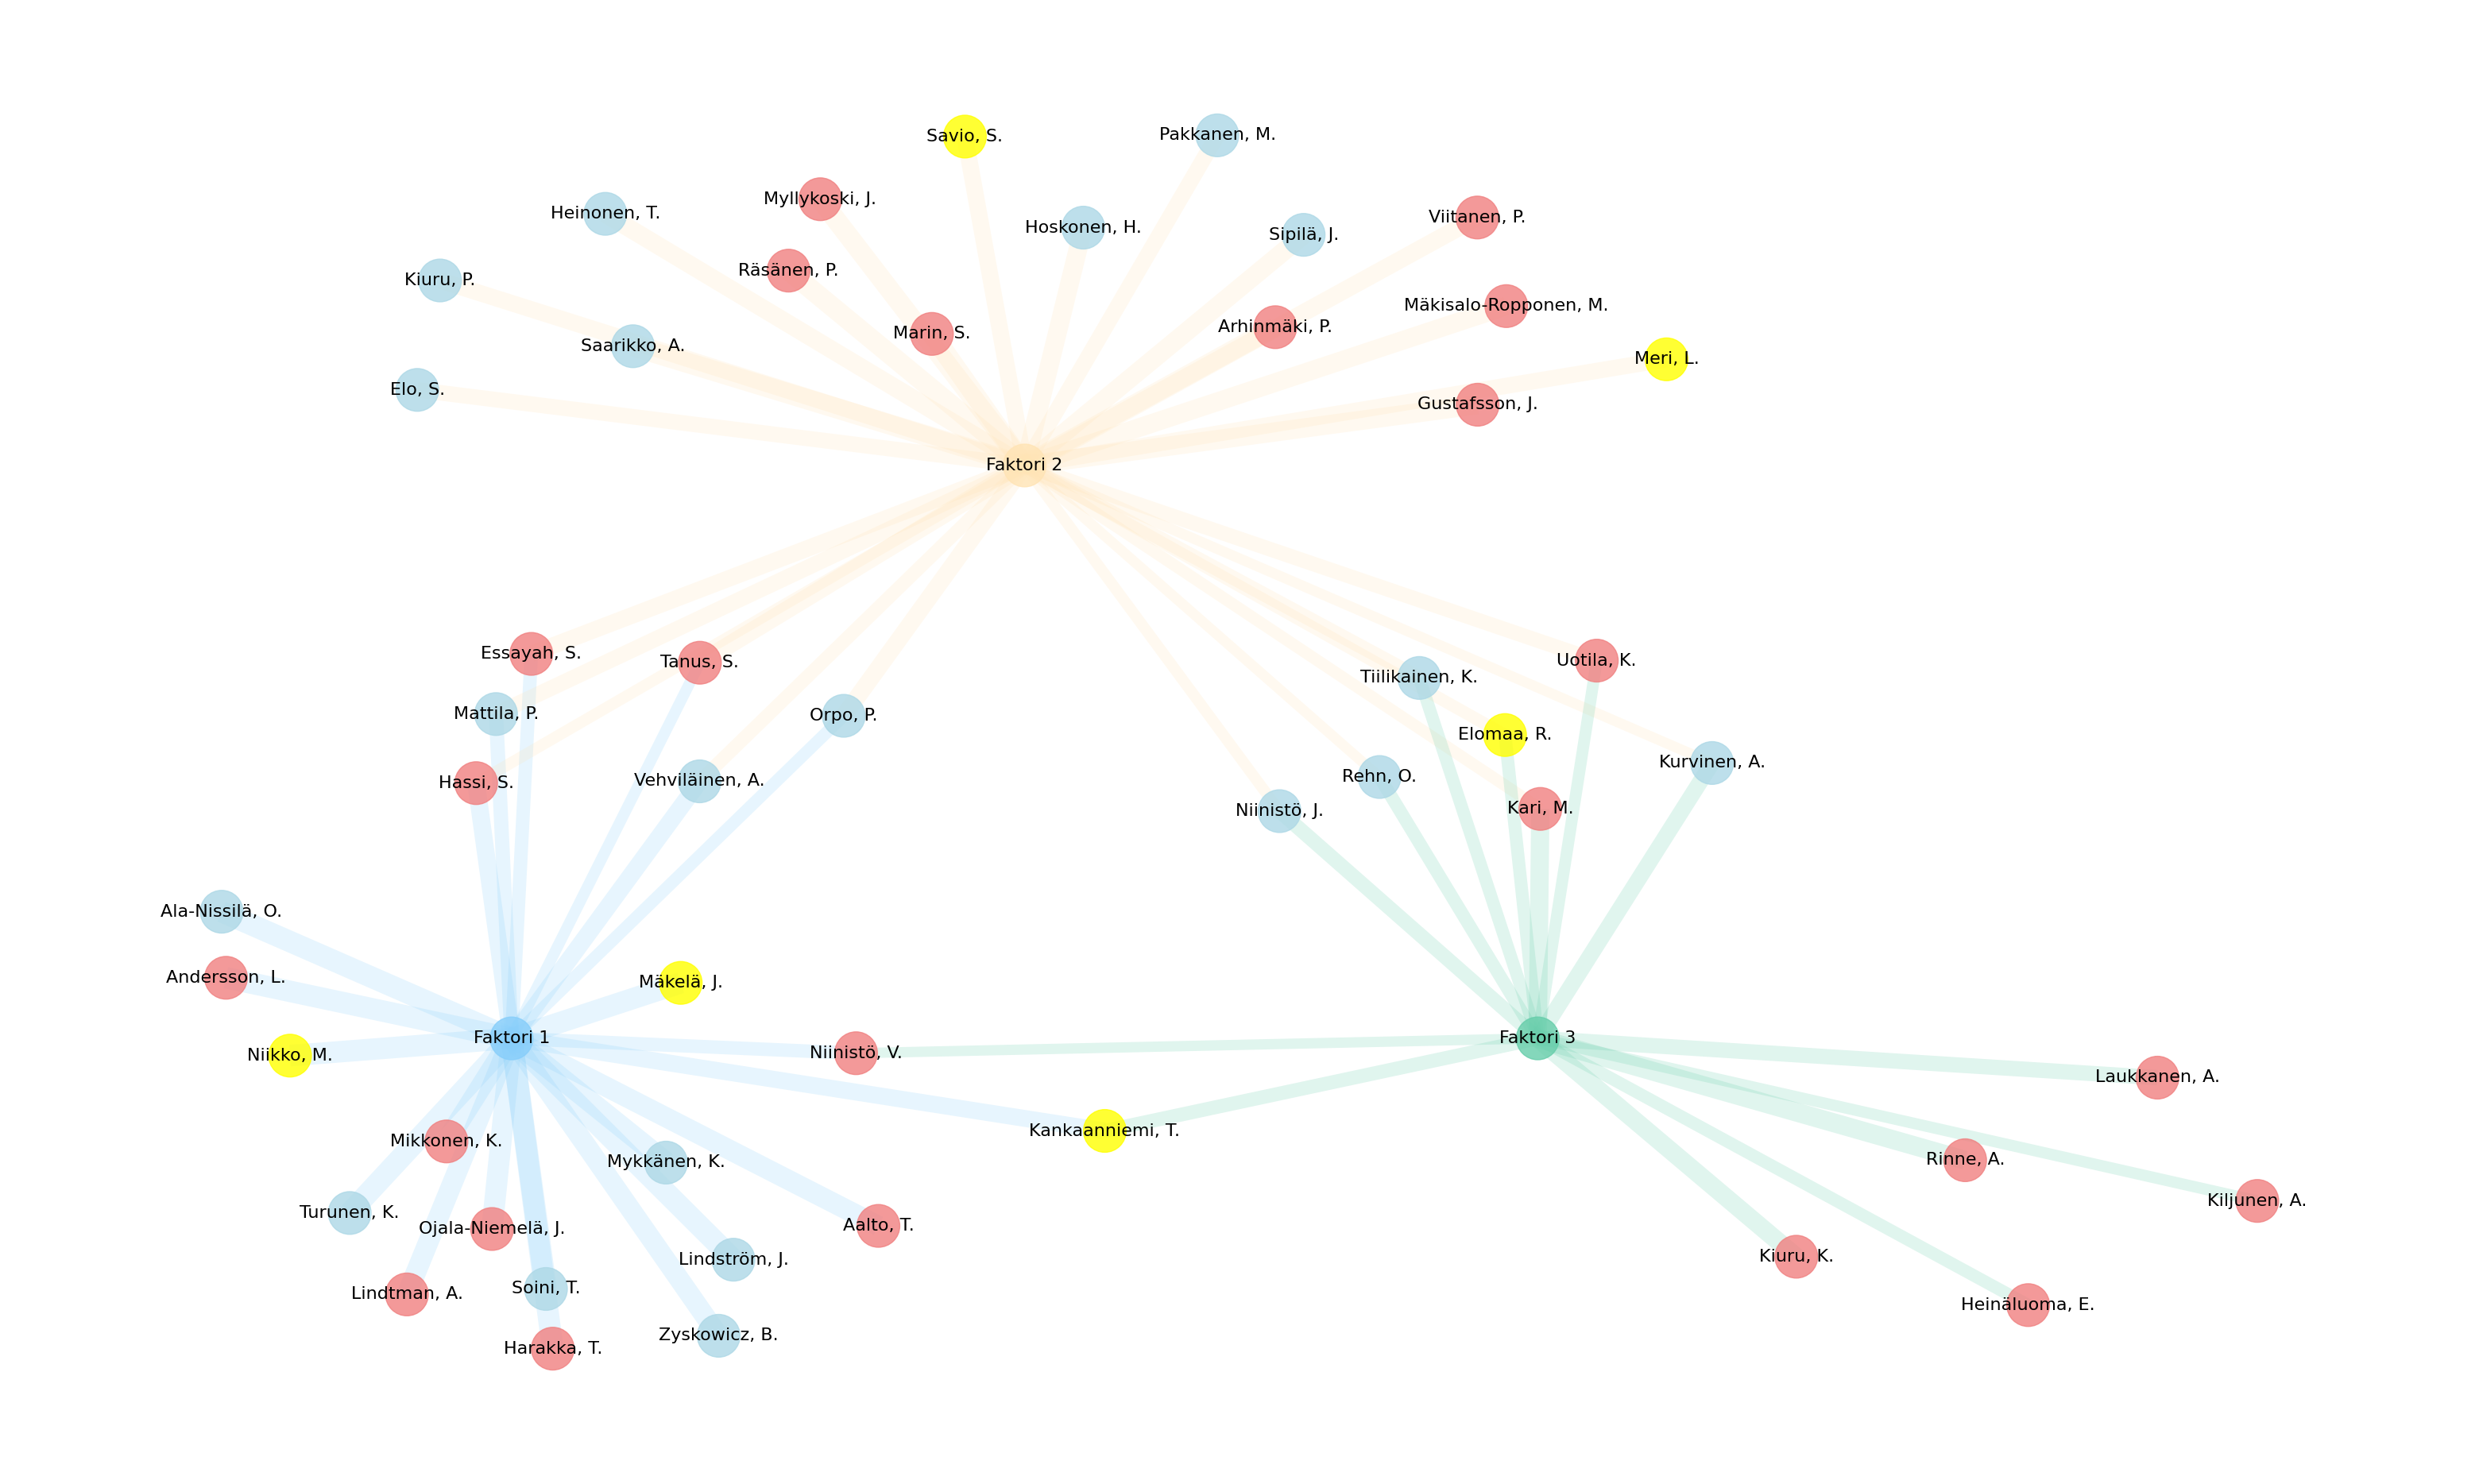

In [ ]:
fcolors = ['lightskyblue', 'moccasin', 'mediumaquamarine','thistle','burlywood','lightgrey','darkkhaki','teal']

FG = nx.Graph()
labels = {}
nodes = []
ncolors = []
c_nodes = []
for i in range(factors):
  node = "Faktori " + str(i+1)
  FG.add_node(i)
  #colors.append("lightgreen")
  ncolors.append(fcolors[i])
  labels[i] = node
  c_nodes.append(i)
print(len(FG.nodes()))
edges = []
mp_nodes = []
i = 0
for (n, data) in G2.nodes(data=True):
  if data['label'] in G2_50_labels:
    FG.add_node(n)
    mp_nodes.append(n)
    #ncolors.append("blue")
    parts = data["label"].split(" ")#[0][:-1]
    labels[n] = parts[0] + " " + parts[1][0] + "."
    for j in range(factors):
      if fa.loadings_.round(2)[i][j] >= 0.4:
        FG.add_edge(n, j, weight=fa.loadings_.round(2)[i][j], color=fcolors[j])
    i += 1

print(len(ncolors))
print(len(labels))
print(len(FG.nodes()))
print(len(G2.nodes()))

remove =  [node for node,degree in dict(FG.degree()).items() if degree == 0]
print(remove)
FG.remove_nodes_from(remove)
for r in remove:
  mp_nodes.remove(r)
#ncolors += [G2.nodes[n]['color'] for n in mp_nodes]#["yellow"]*(len(FG.nodes())-factors)
ncolors += [gov_colors[G2.nodes[n]['group']] for n in mp_nodes]
for n in remove:
    labels.pop(n, None)

pos = nx.random_layout(FG)
x0 = -4
y0 = -1.5
for n in c_nodes:
  pos[n][0] = x0
  pos[n][1] = y0
  y0 *= -1
  x0 += 1.2


edge_colors = [d['color'] for _,_,d in FG.edges(data=True)]
#pos = graphviz_layout(FG, prog="twopi")
pos = nx.spring_layout(FG, pos=pos, fixed=c_nodes, k=0.5, iterations=20)
pos = drawGraph(FG, pos=pos, labels=labels, node_color=ncolors, edge_color=edge_colors, min_e=0, max_e=1.0)
